# Methow Boxplots

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
from rasterstats import zonal_stats
import hvplot.pandas
import pickle
from scipy import stats
from scipy.signal import savgol_filter
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [7]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [8]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [9]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

In [10]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [11]:
mpl_epoch = '1970-01-01'

In [12]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Load in the saved data:

In [14]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_methow/notebooks/figure_production


In [319]:
atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/methow_outline_32610.pkl', 'rb'))

methow_reverse = pickle.load(open('../../../data/site_outlines/methow_reverse.pkl', 'rb'))

snwd = pickle.load(open('../../data/snotel/snotel_snwd_35.pkl', 'rb'))
snwd_65 = pickle.load(open('../../data/snotel/snotel_snwd_65.pkl', 'rb'))
snotel_sites = pickle.load(open('../../data/snotel/snotel_sites_65.pkl', 'rb'))

snotel_geom = pickle.load(open('../../data/snotel/snotel_geometries.pkl', 'rb'))

cso_methow = pickle.load(open('../../../data/cso/cso-data.pkl', 'rb'))

In [18]:
import myfunctions
from myfunctions import boxplot_date_aso_all

In [19]:
snow_columns = ['tum_m', 'dan_clean']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'dt_min_plot' is not defined

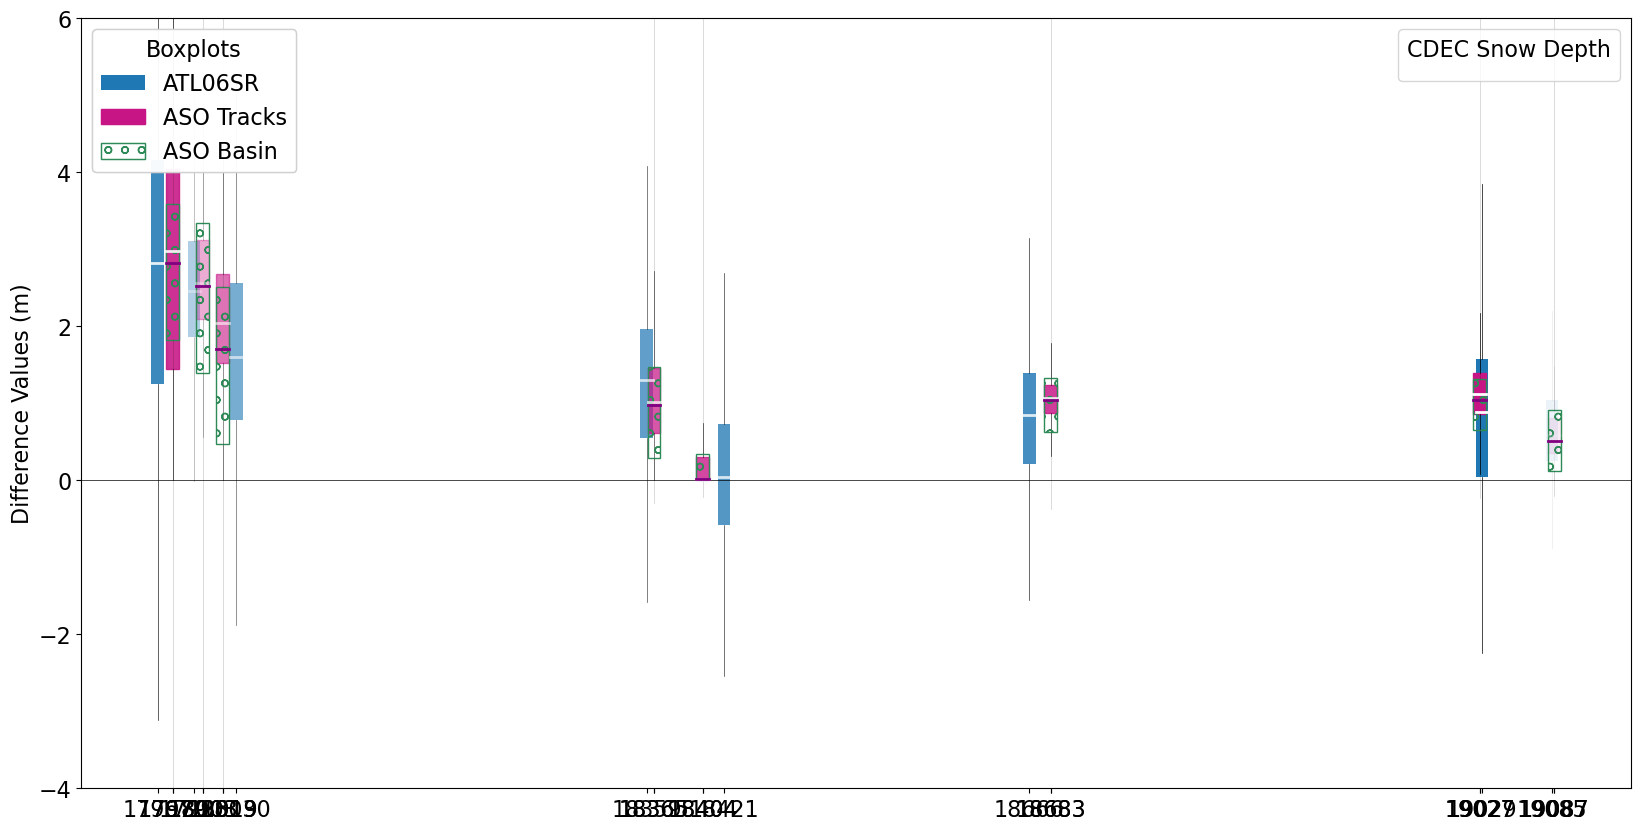

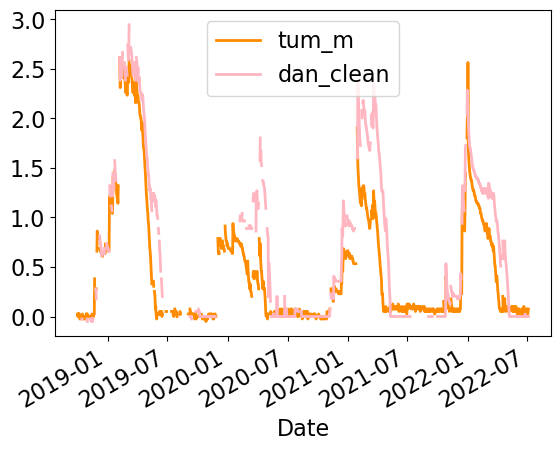

In [20]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', snow_df=snwd, snow_columns=snow_columns, region_aso=outline_gdf, rasterstats=True, snowon_list=aso_fn_winters, clim=(-4,6))

## Create Transparent Boxplots

Playing with parameters to see how each piece works:

In [179]:
bp_stats = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').apply(cbook.boxplot_stats)
bp_stats_list = [i[0] for i in bp_stats.values]
bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
bp_alpha_boxes = bp_alpha/bp_alpha.max()
pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values

In [187]:
bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.25) + 0.25
#norm * (newRange[1] - newRange[0]) + newRange[0]

In [ ]:
(x-min(x))/(max(x)-min(x))

In [188]:
bp_alpha_boxes

array([0.34283965, 0.87270962, 0.28375412, 0.89924428, 0.85067128,
       0.26070252, 0.26025922, 0.395529  , 0.25234316, 0.34144642,
       0.2531031 , 0.73066368, 0.29432998, 0.58874441, 0.30914886,
       0.25050663, 0.54010808, 0.25006333, 0.77410707, 0.25766275,
       1.        , 0.31313856, 0.29027696, 0.74706578, 0.29072026,
       0.6708182 , 0.30794562, 0.73338681, 0.28033437, 0.25468631,
       0.7185046 , 0.25272313, 0.45062484, 0.27222832, 0.56081652,
       0.27197501, 0.34334628, 0.55986659, 0.35297222, 0.25031664,
       0.2999029 , 0.25      , 0.26158912, 0.27609136, 0.56841594,
       0.25500296, 0.4070548 , 0.25189986, 0.25025331, 0.2517732 ,
       0.25240648, 0.47392975, 0.26735202, 0.7608714 , 0.27235498,
       0.25126657])

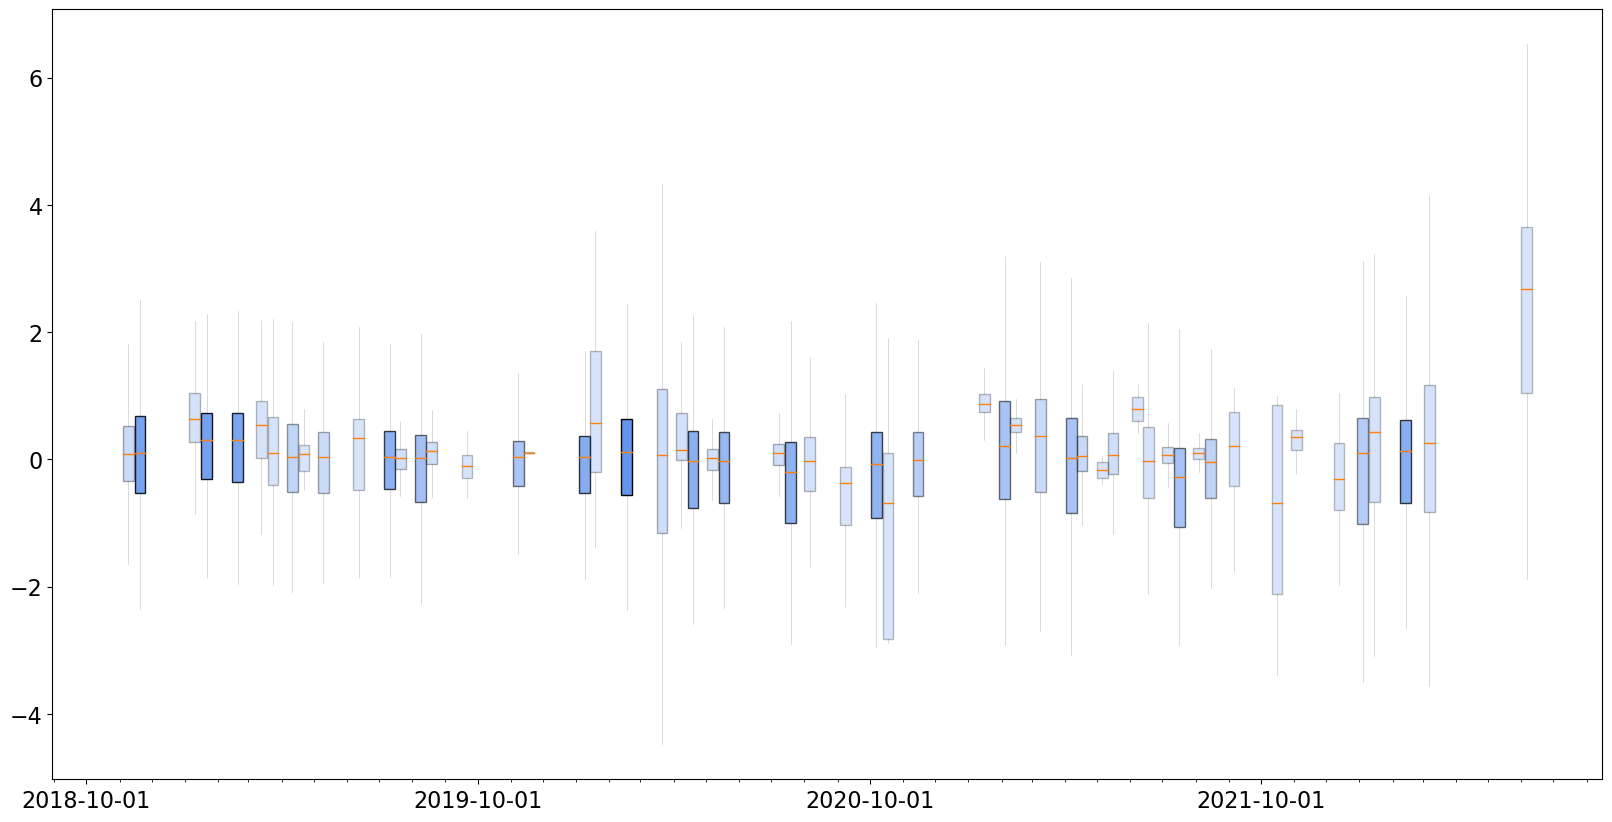

In [189]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'

f, ax = plt.subplots(figsize=(20,10))
bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, widths=10, patch_artist=True)

for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
    patch.set_alpha(alpha)
    patch.set_facecolor('cornflowerblue')

years = mdates.YearLocator(month=10)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
years_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
months = mdates.MonthLocator()
ax.xaxis.set_minor_locator(months)

### Transparent Boxplots with CDEC and ATL06SR Data

In [175]:
snwd

,Muckamuck,Salmon Meadows,doy,decyear,dowy,acqdate
2018-10-03,0.0,0.0,276,2018.753425,3,2018-10-03
2018-10-04,0.0,0.0,277,2018.756164,4,2018-10-04
2018-10-05,0.0,0.0,278,2018.758904,5,2018-10-05
2018-10-06,0.0,0.0,279,2018.761644,6,2018-10-06
2018-10-07,0.0,0.0,280,2018.764384,7,2018-10-07
...,...,...,...,...,...,...
2022-10-14,0.0,0.0,287,2022.783562,14,2022-10-14
2022-10-15,0.0,0.0,288,2022.786301,15,2022-10-15
2022-10-16,0.0,0.0,289,2022.789041,16,2022-10-16
2022-10-17,0.0,0.0,290,2022.791781,17,2022-10-17


In [229]:
snwd_65

,Pope Ridge,Lyman Lake,Park Creek Ridge,Rainy Pass,Thunder Basin,Swamp Creek,Muckamuck,Salmon Meadows,Harts Pass,doy,decyear,dowy,acqdate
2018-10-03,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276,2018.753425,3,2018-10-03
2018-10-04,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277,2018.756164,4,2018-10-04
2018-10-05,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,278,2018.758904,5,2018-10-05
2018-10-06,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279,2018.761644,6,2018-10-06
2018-10-07,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280,2018.764384,7,2018-10-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-18,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,291,2022.794521,18,2022-10-18
2022-10-19,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292,2022.797260,19,2022-10-19
2022-10-20,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293,2022.800000,20,2022-10-20
2022-10-21,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,294,2022.802740,21,2022-10-21


In [259]:
snwd_65[snotel_sites[snotel_sites['elevation_m']<1000]['name']]

""
2018-10-03
2018-10-04
2018-10-05
2018-10-06
2018-10-07
...
2022-10-18
2022-10-19
2022-10-20
2022-10-21


In [241]:
len(snotel_sites)

10

In [250]:
snotel_sites

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:699_WA_SNTL,699_WA_SNTL,Pope Ridge,SNOTEL,1094.232056,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (681575.109 5318154.881),1094.232056
SNOTEL:606_WA_SNTL,606_WA_SNTL,Lyman Lake,SNOTEL,1822.703979,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654799.692 5340403.427),1822.703979
SNOTEL:681_WA_SNTL,681_WA_SNTL,Park Creek Ridge,SNOTEL,1402.079956,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654147.806 5367847.622),1402.079956
SNOTEL:711_WA_SNTL,711_WA_SNTL,Rainy Pass,SNOTEL,1490.472046,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (667193.867 5376424.178),1490.472046
SNOTEL:817_WA_SNTL,817_WA_SNTL,Thunder Basin,SNOTEL,1316.735962,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (648435.062 5376887.468),1316.735962
SNOTEL:975_WA_SNTL,975_WA_SNTL,Swamp Creek,SNOTEL,1197.864014,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (663563.081 5382187.777),1197.864014
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959
SNOTEL:515_WA_SNTL,515_WA_SNTL,Harts Pass,SNOTEL,1978.151978,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (672206.062 5399027.491),1978.151978


In [244]:
snwd_65.columns

Index(['Pope Ridge', 'Lyman Lake', 'Park Creek Ridge', 'Rainy Pass',
       'Thunder Basin', 'Swamp Creek', 'Muckamuck', 'Salmon Meadows',
       'Harts Pass', 'doy', 'decyear', 'dowy', 'acqdate'],
      dtype='object')

In [239]:
snotel_sites

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:699_WA_SNTL,699_WA_SNTL,Pope Ridge,SNOTEL,1094.232056,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (681575.109 5318154.881),1094.232056
SNOTEL:262_WA_SNTL,262_WA_SNTL,Mirror Lake,SNOTEL,1706.880005,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (674785.221 5335643.219),1706.880005
SNOTEL:606_WA_SNTL,606_WA_SNTL,Lyman Lake,SNOTEL,1822.703979,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654799.692 5340403.427),1822.703979
SNOTEL:681_WA_SNTL,681_WA_SNTL,Park Creek Ridge,SNOTEL,1402.079956,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654147.806 5367847.622),1402.079956
SNOTEL:711_WA_SNTL,711_WA_SNTL,Rainy Pass,SNOTEL,1490.472046,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (667193.867 5376424.178),1490.472046
SNOTEL:817_WA_SNTL,817_WA_SNTL,Thunder Basin,SNOTEL,1316.735962,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (648435.062 5376887.468),1316.735962
SNOTEL:975_WA_SNTL,975_WA_SNTL,Swamp Creek,SNOTEL,1197.864014,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (663563.081 5382187.777),1197.864014
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959
SNOTEL:515_WA_SNTL,515_WA_SNTL,Harts Pass,SNOTEL,1978.151978,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (672206.062 5399027.491),1978.151978


In [235]:
snotel_list=['Muckamuck', 'Salmon Meadows']
color_list = ['darkorange', 'lightpink', 'lightcoral']
color_list[0:len(snotel_list)]

['darkorange', 'lightpink']

In [278]:
cso_methow.head(2)

,id,author,depth,source,timestamp,elevation,_ms,geometry,depth_m
time,,,,,,,,,
2020-02-02 22:08:04.920000+00:00,uO/sQItI,Becca Windell,11.0,MountainHub,2020-02-02 22:08:04.920000+00:00,793.541260,1580681284920,POINT (714141.047 5351662.789),0.11
2020-01-12 21:24:45.782000+00:00,p5dR+JQH,Nicholas Lowing,5.0,MountainHub,2020-01-12 21:24:45.782000+00:00,1089.261475,1578864285782,POINT (711207.136 5356123.010),0.05


<AxesSubplot: xlabel='time'>

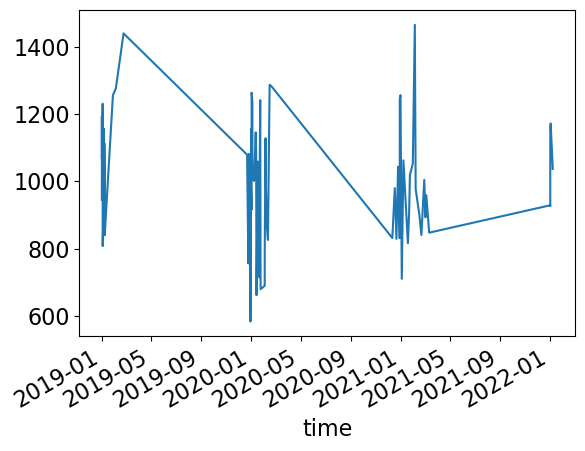

In [300]:
cso_methow['elevation'].plot()

In [309]:
# Function adapted from David Shean by Hannah Besso
# Uses boxplot transparency to indicate sample size

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', 
                         groupby_col_aso='ASO_snowon_date', snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], region_aso=outline_gdf, 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    # snwd['Muckamuck'].plot(alpha=1, color='darkorange', lw=2, label='Muckamuck')
    # snwd['Salmon Meadows'].plot(alpha=1, color='lightpink', lw=2, label='Salmon Meadows')
    color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    snwd_65[snotel_list].plot(ax=ax, lw=2, color=color_list[0:len(snotel_list)])
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='k', linewidth=0, marker='.')
    #snwd_65.iloc[:,0:9].plot(ax=ax, lw=2)
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'alpha':1}, 
                        medianprops={'lw':3, 'color':'purple'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('mediumvioletred')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('grey')
            patch.set_edgecolor('none')
            patch.set_alpha(alpha)
            #patch.set_hatch('o')
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='lower right', title='SNOTEL Snow Depth')
    legend1.set_alpha(1)
    if rasterstats:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    elif col_aso != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    else:
        legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_alpha(alpha)    
        for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
            patch.set_alpha(alpha)
            patch.set_color('white')  # or deeppink
        #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
        for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
            patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
#     months = mdates.MonthLocator()
#     ax.format_xdata = mdates.DateFormatter('%m')
#     months_fmt = mdates.DateFormatter('%m')
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    #plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

In [363]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', 
                         groupby_col_aso='ASO_snowon_date', snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], region_aso=outline_gdf, 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    # snwd['Muckamuck'].plot(alpha=1, color='darkorange', lw=2, label='Muckamuck')
    # snwd['Salmon Meadows'].plot(alpha=1, color='lightpink', lw=2, label='Salmon Meadows')
    color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    snwd_65[snotel_list].plot(ax=ax, lw=2, color=color_list[0:len(snotel_list)])
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='k', linewidth=0, marker='.')
    #snwd_65.iloc[:,0:9].plot(ax=ax, lw=2)
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='lower right', title='SNOTEL Snow Depth')
    #legend1.set_alpha(1)
    legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(1)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(0.8)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    # for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
    #     patch.set_alpha(0.8)
        
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
#     months = mdates.MonthLocator()
#     ax.format_xdata = mdates.DateFormatter('%m')
#     months_fmt = mdates.DateFormatter('%m')
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    #plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

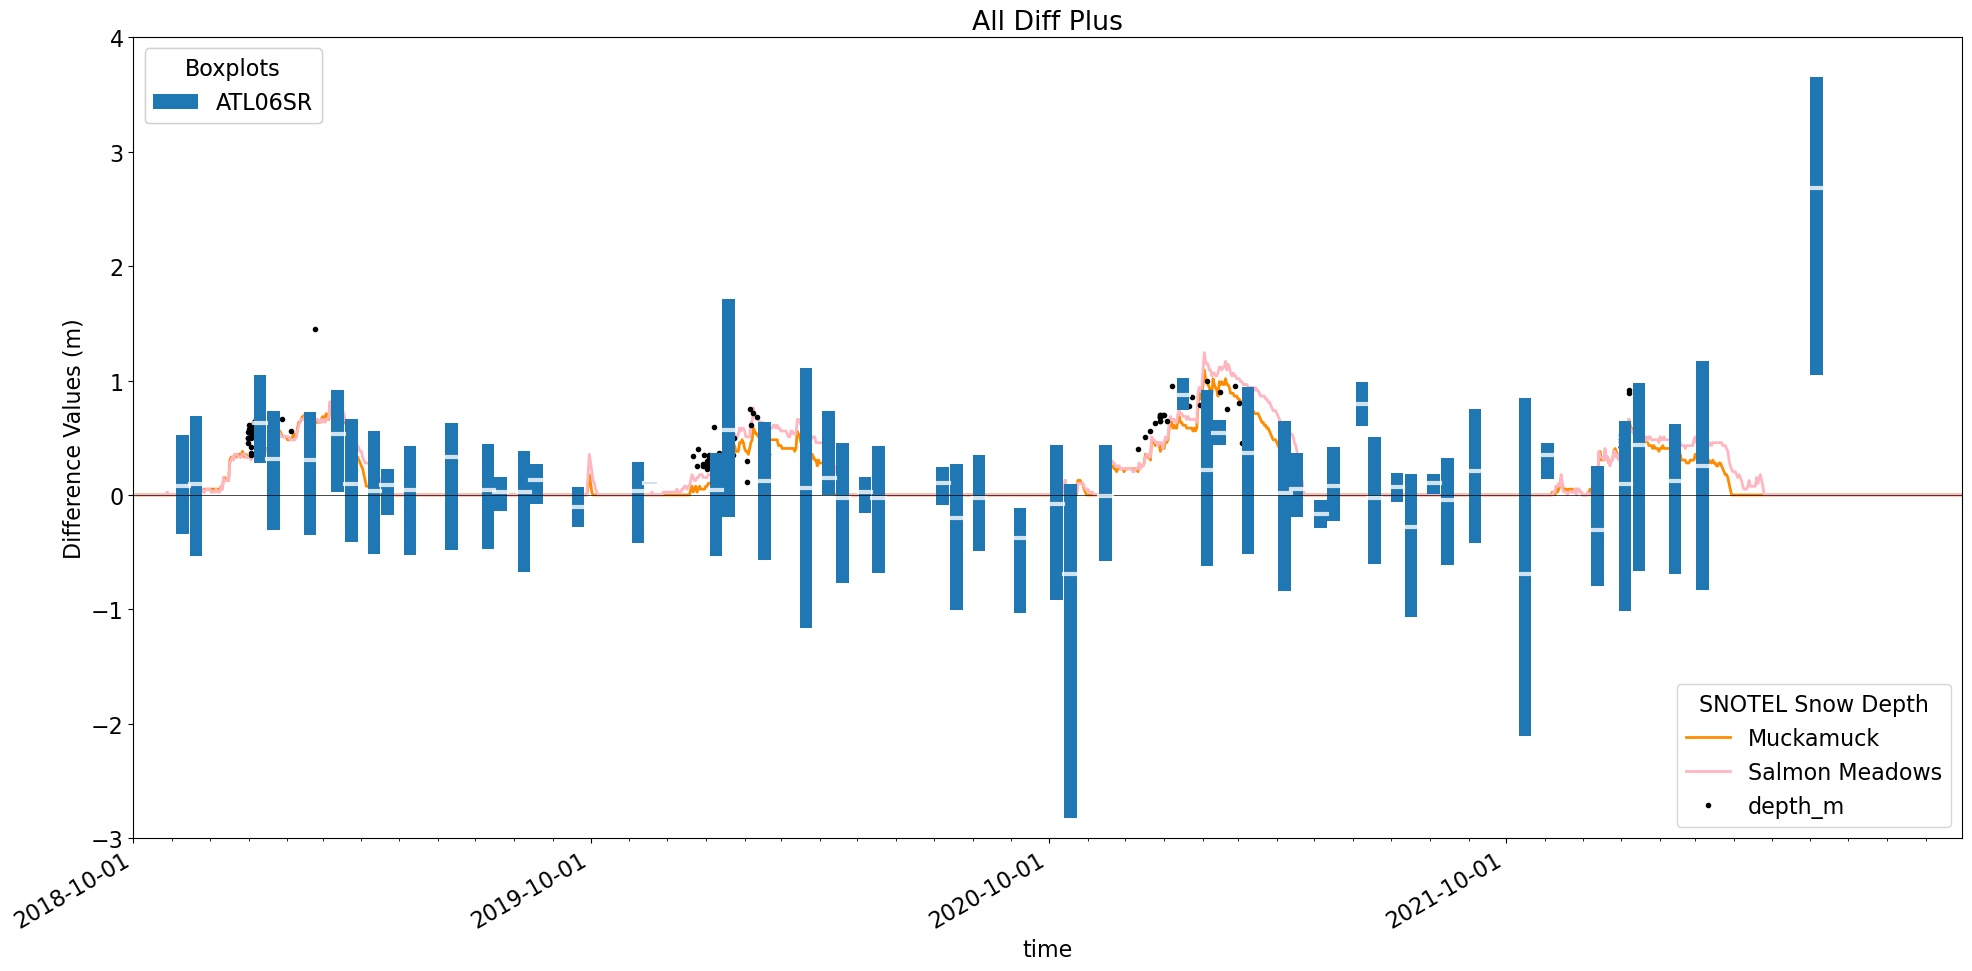

In [364]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-3,4), name='boxplots_diffplus', title='All Diff Plus')

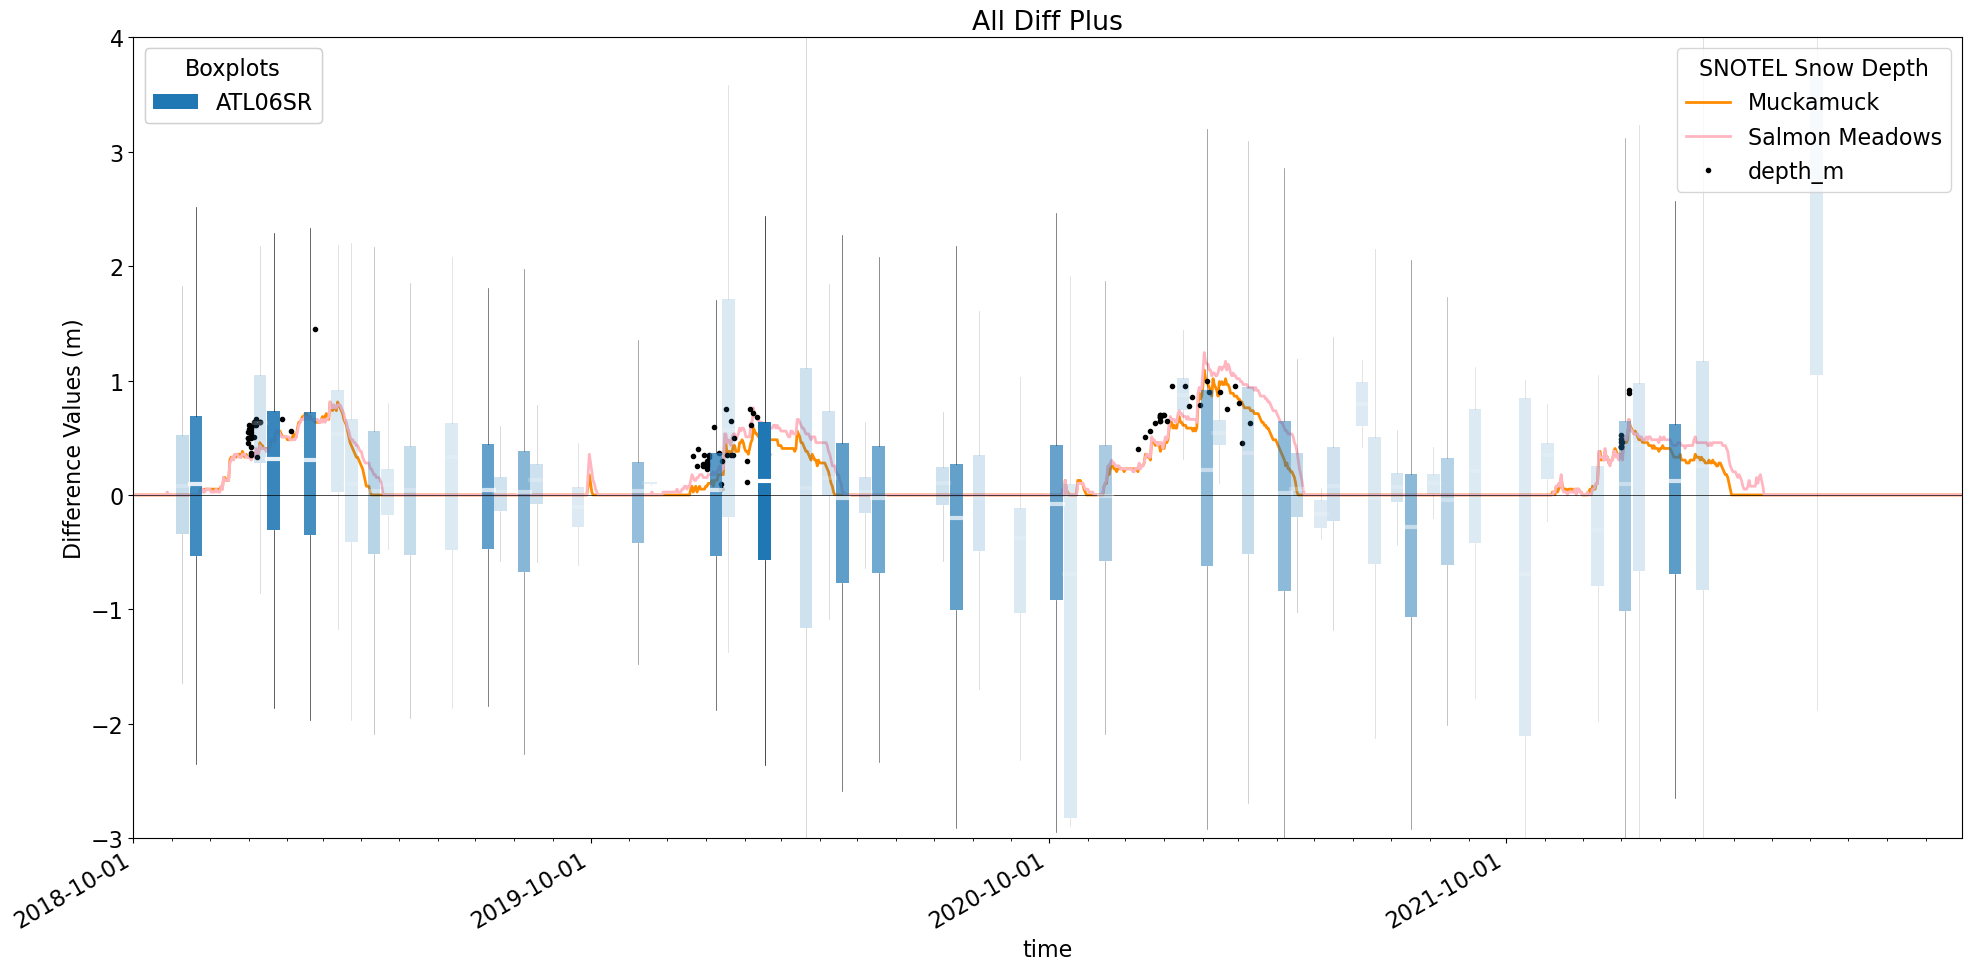

In [295]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-3,4), name='boxplots_diffplus', title='All Diff Plus')

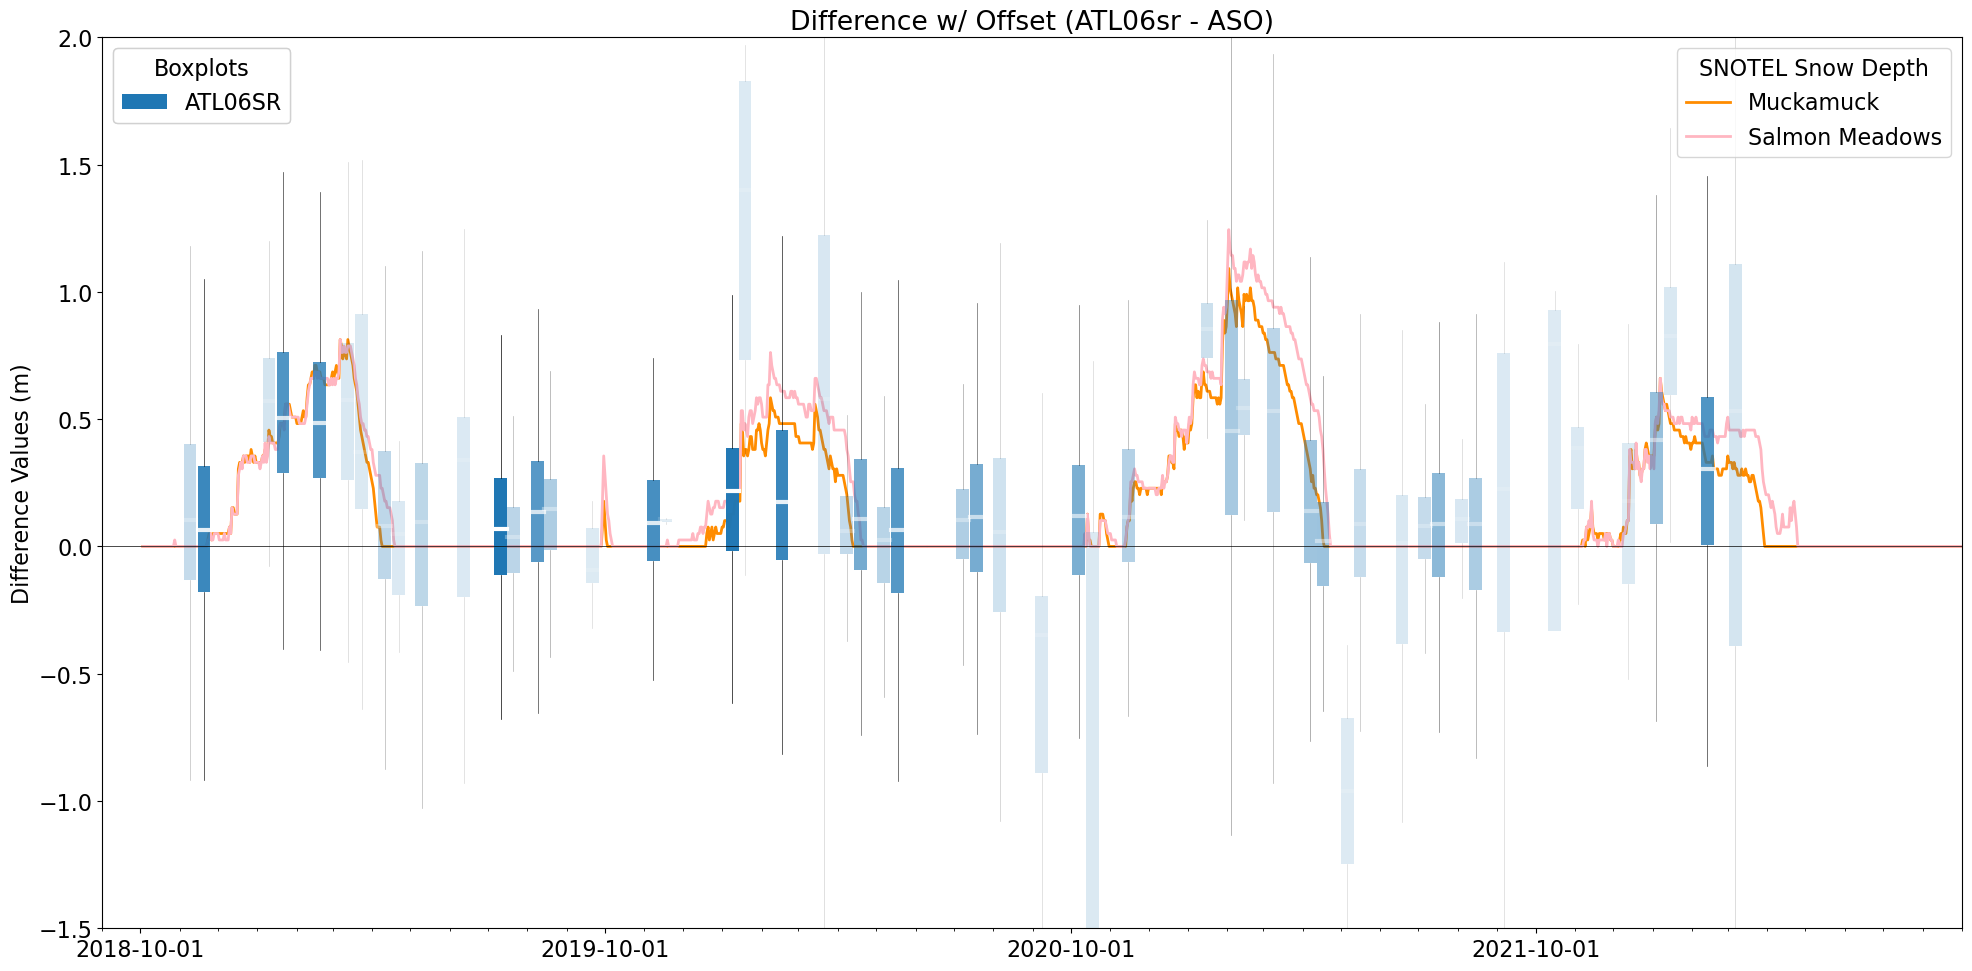

In [237]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m']<10], 'diff_plus', clim=(-1.5,2), title = 'Difference w/ Offset (ATL06sr - ASO)', name = 'boxplots_diffplus_slope10')

# Separate Diff Plus by Elevation

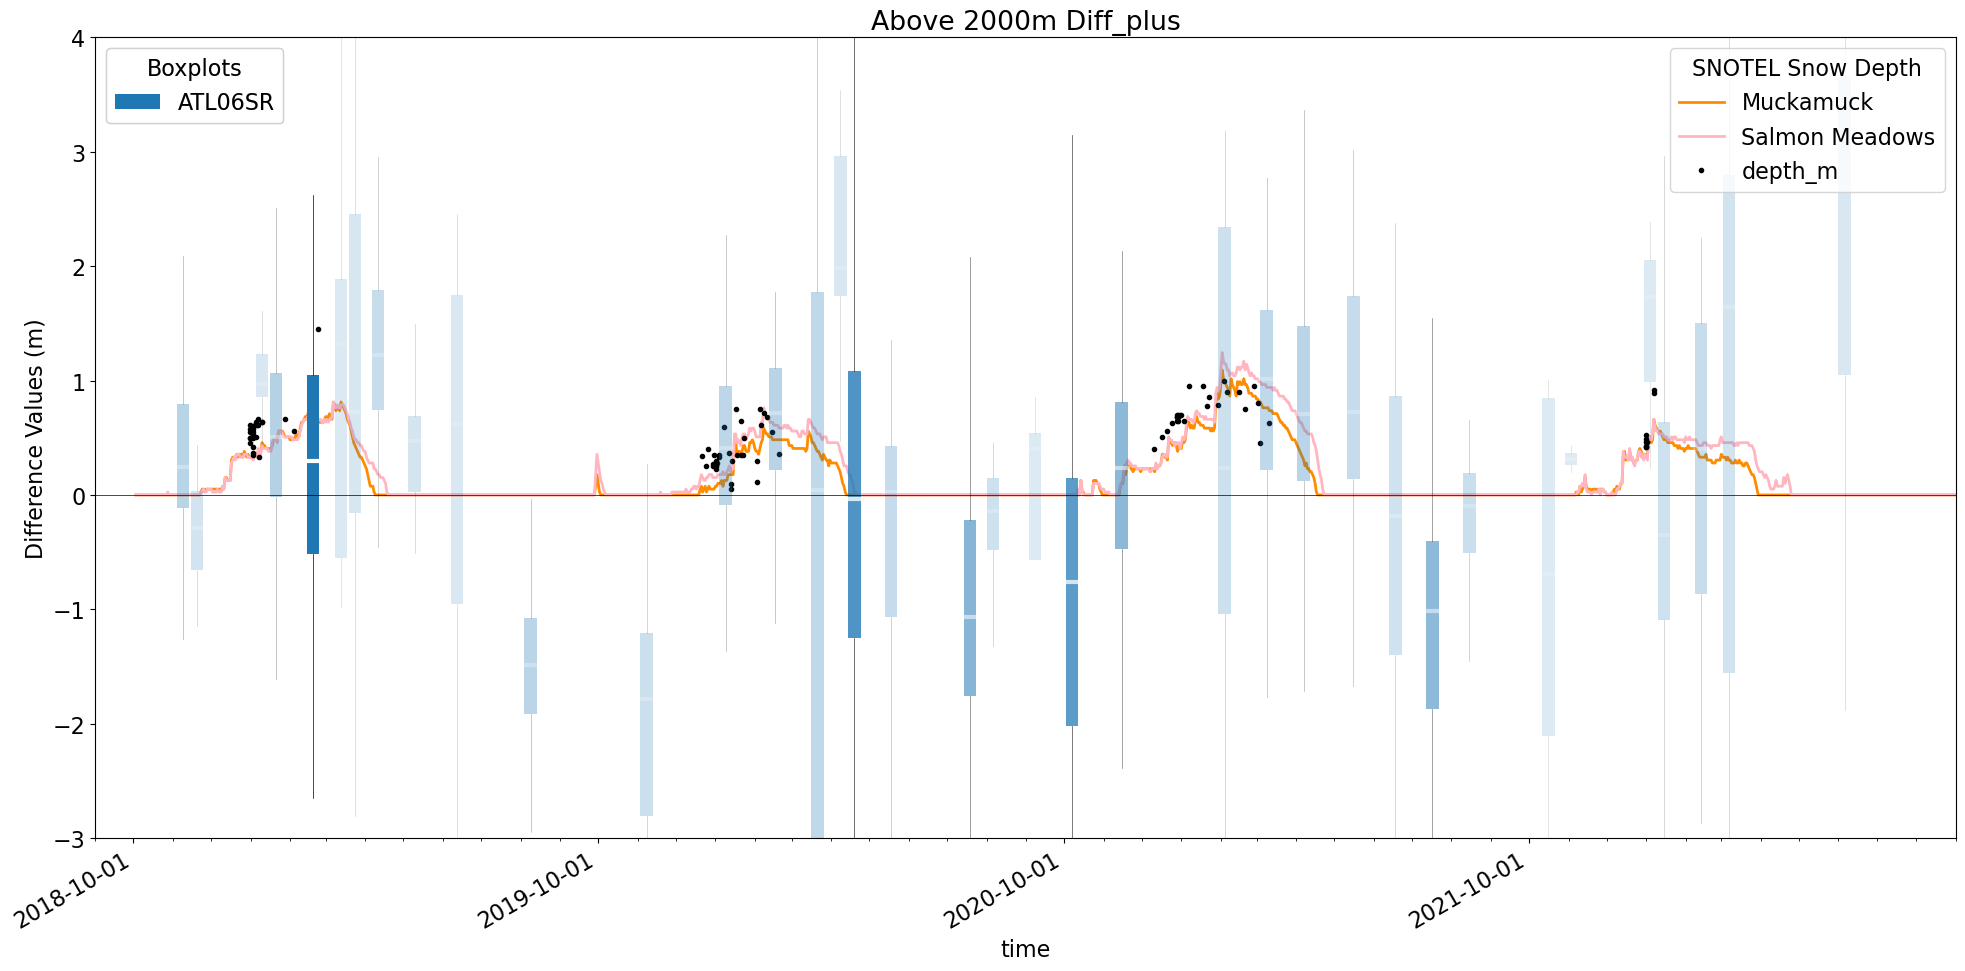

In [297]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['lidar_z']>2000], 'diff_plus', clim=(-3,4), title = 'Above 2000m Diff_plus', name = 'boxplots_diffplus_slope10')

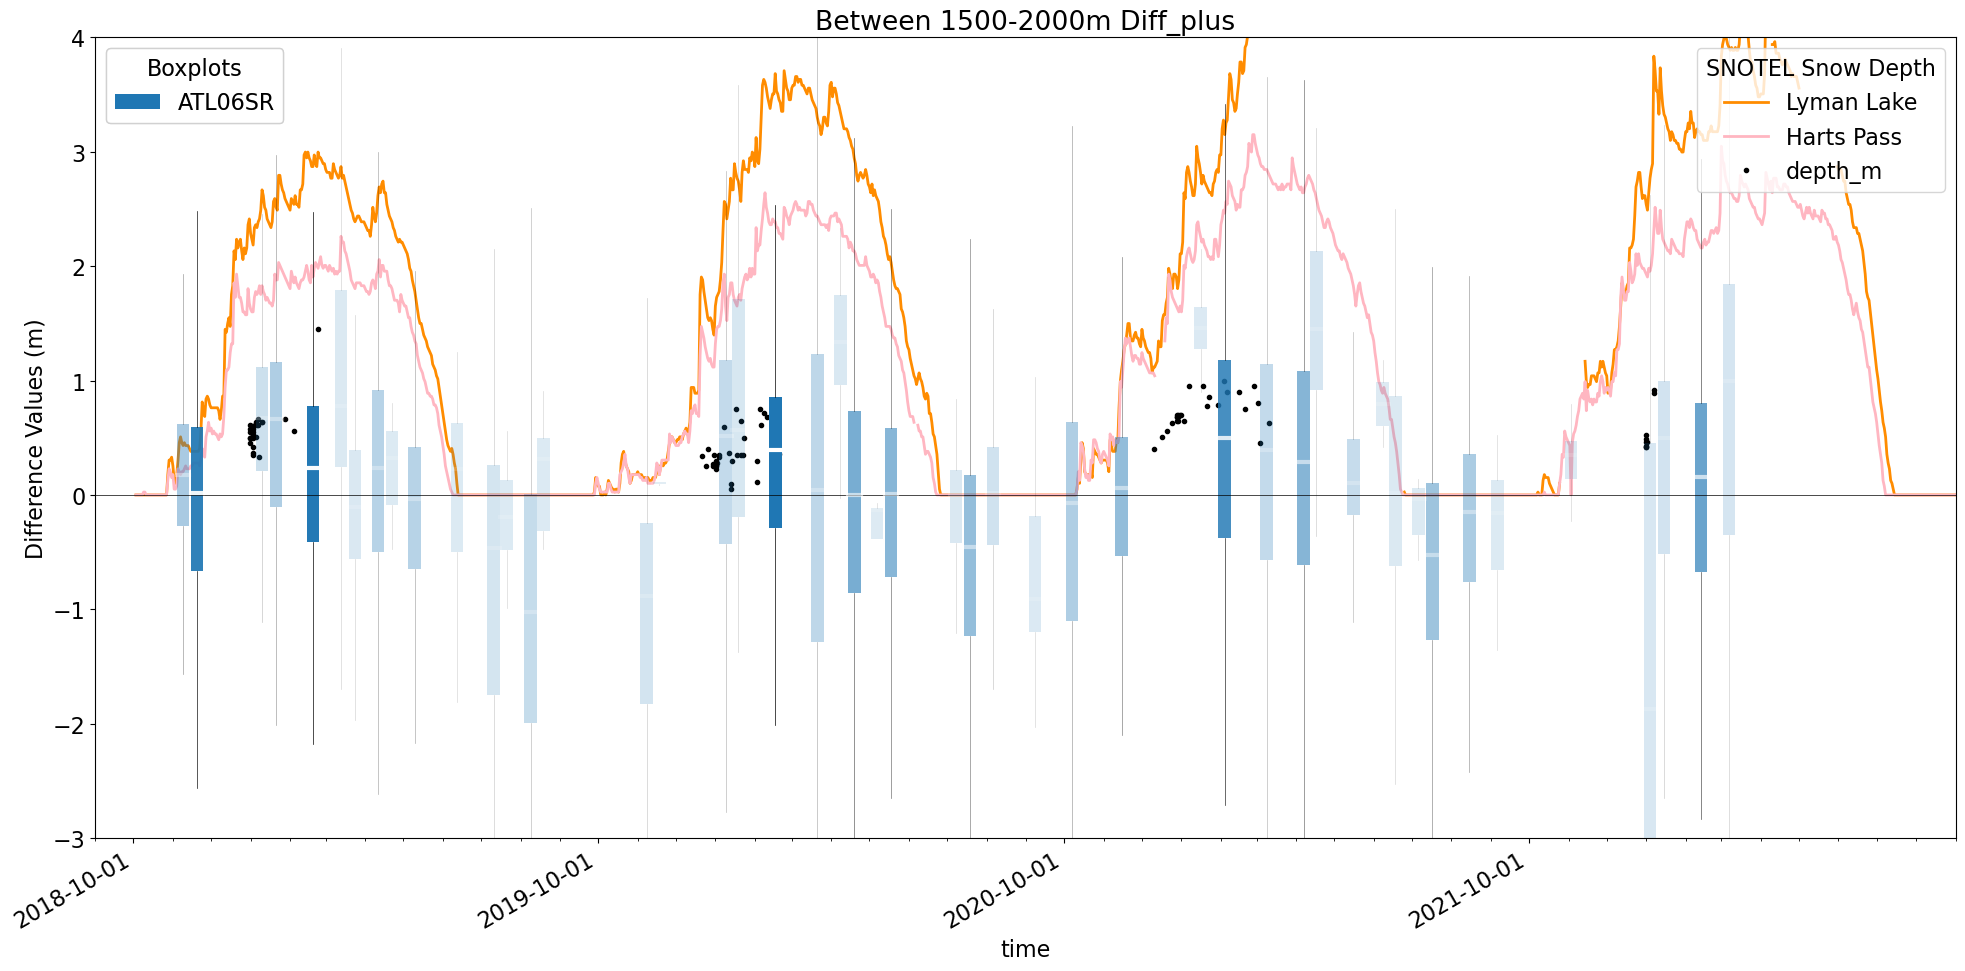

In [301]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<2000) & (atl06sr_gdf['lidar_z']>1500)], 'diff_plus', snotel_list=snotel_sites[snotel_sites['elevation_m']>1500]['name'], clim=(-3,4), title = 'Between 1500-2000m Diff_plus', name = 'boxplots_diffplus_slope10')

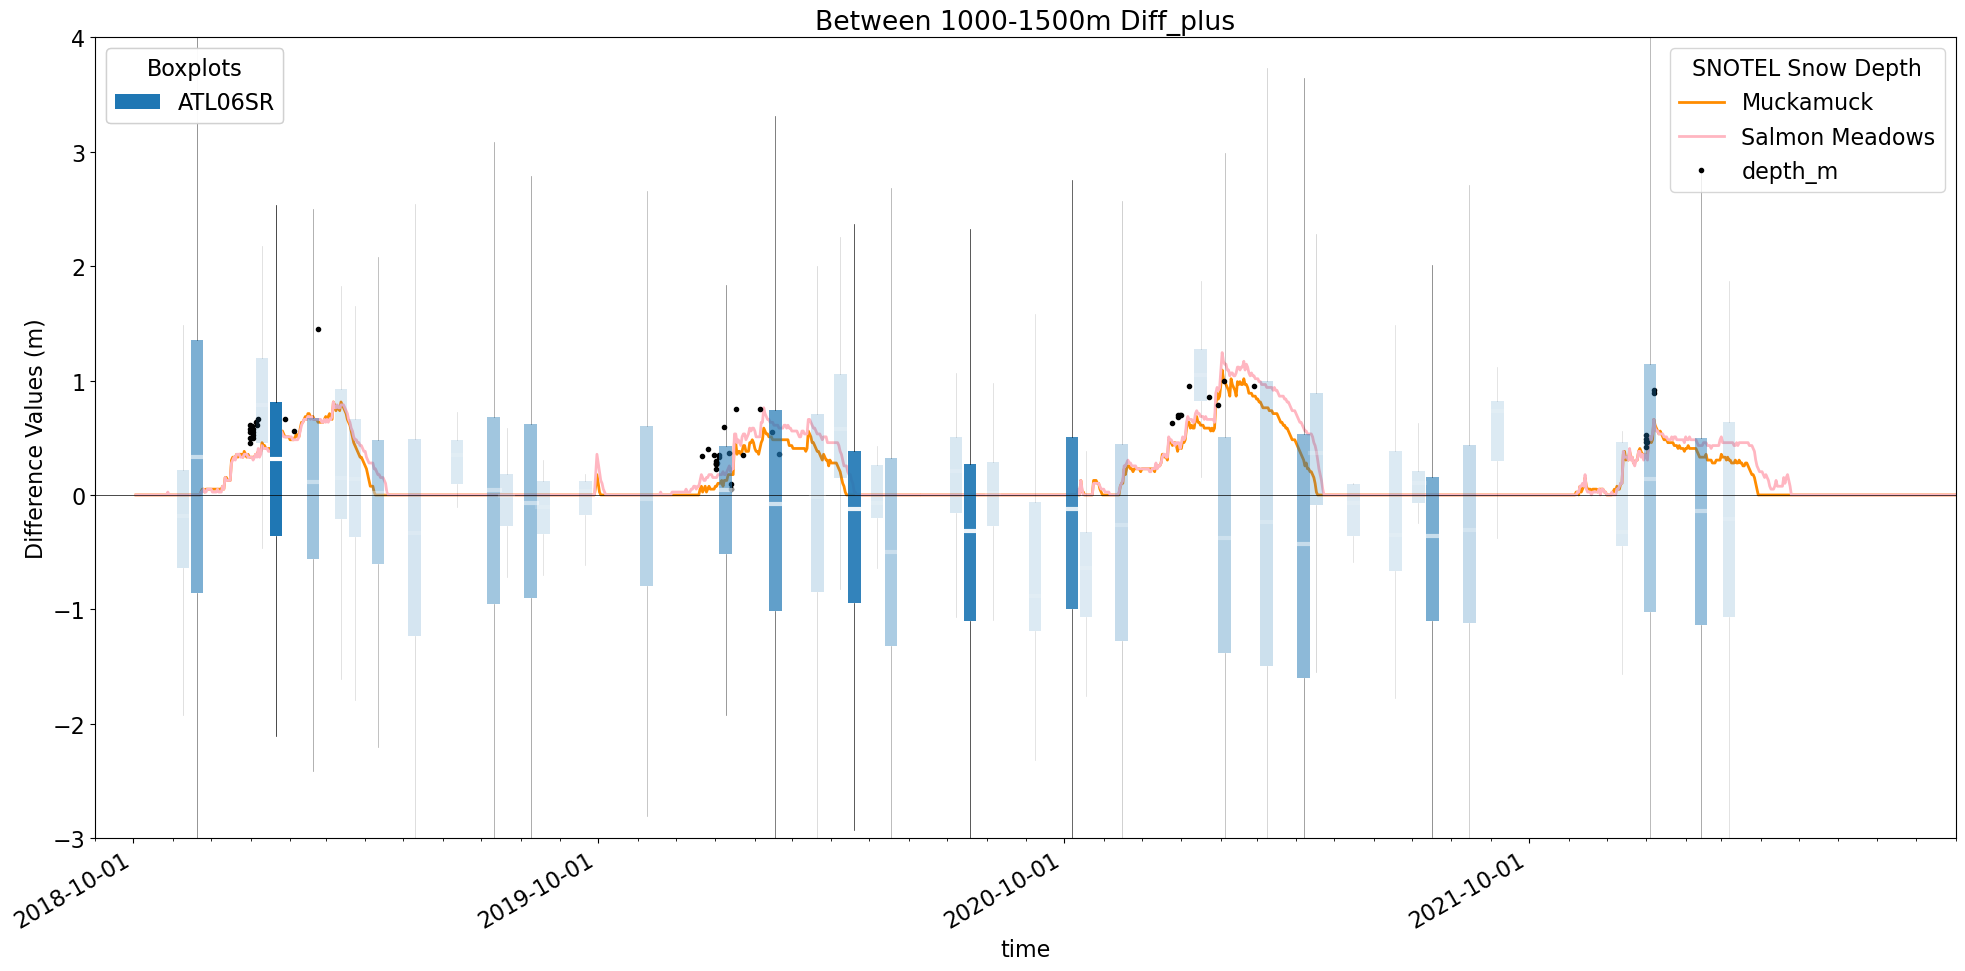

In [302]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<1500) & (atl06sr_gdf['lidar_z']>1000)], 'diff_plus', cso_bounds=[1000, 1500], clim=(-3,4), title = 'Between 1000-1500m Diff_plus', name = 'boxplots_diffplus_slope10')
# snotel_list=snotel_sites[(snotel_sites['elevation_m']<1500) & (snotel_sites['elevation_m']>1000)]['name'],

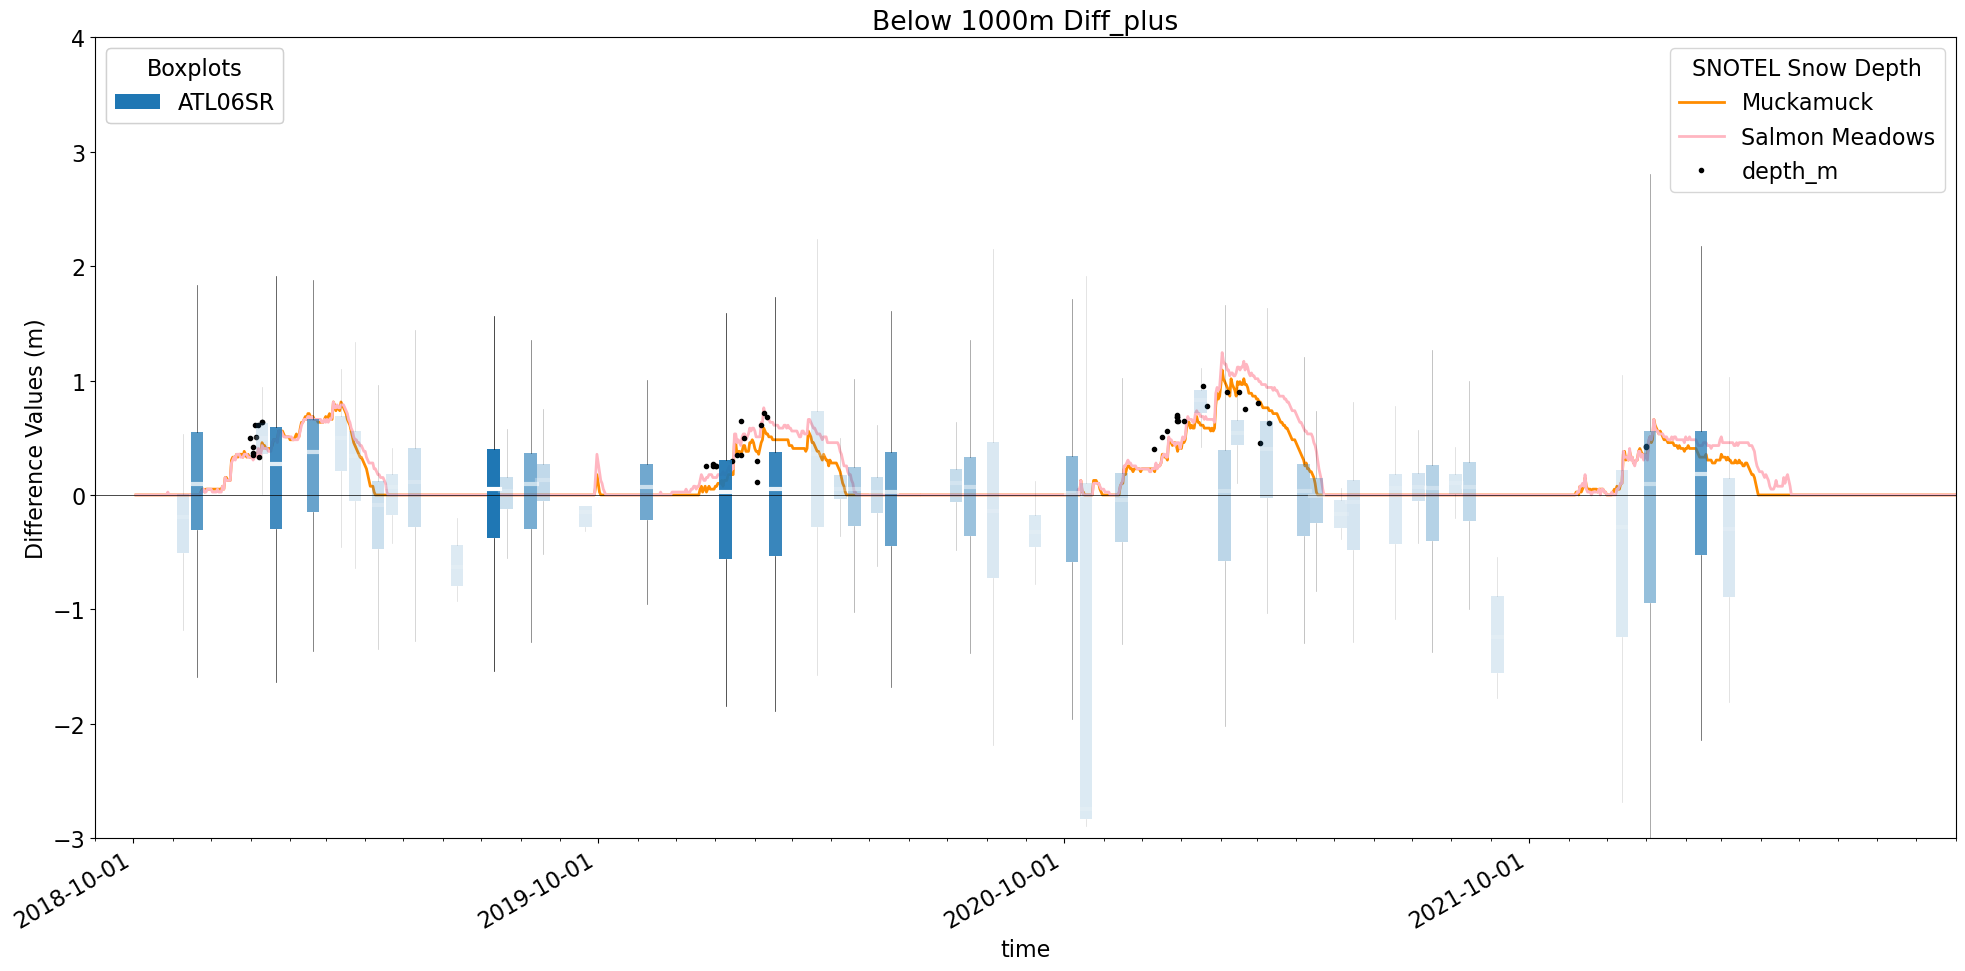

In [303]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['lidar_z']<1000], 'diff_plus', cso_bounds=[0, 1000],  clim=(-3,4), title = 'Below 1000m Diff_plus', name = 'boxplots_diffplus_slope10')
#snotel_list=snotel_sites[snotel_sites['elevation_m']<1000]['name'],

# Separate Diff Plus Low Slope By Elevation

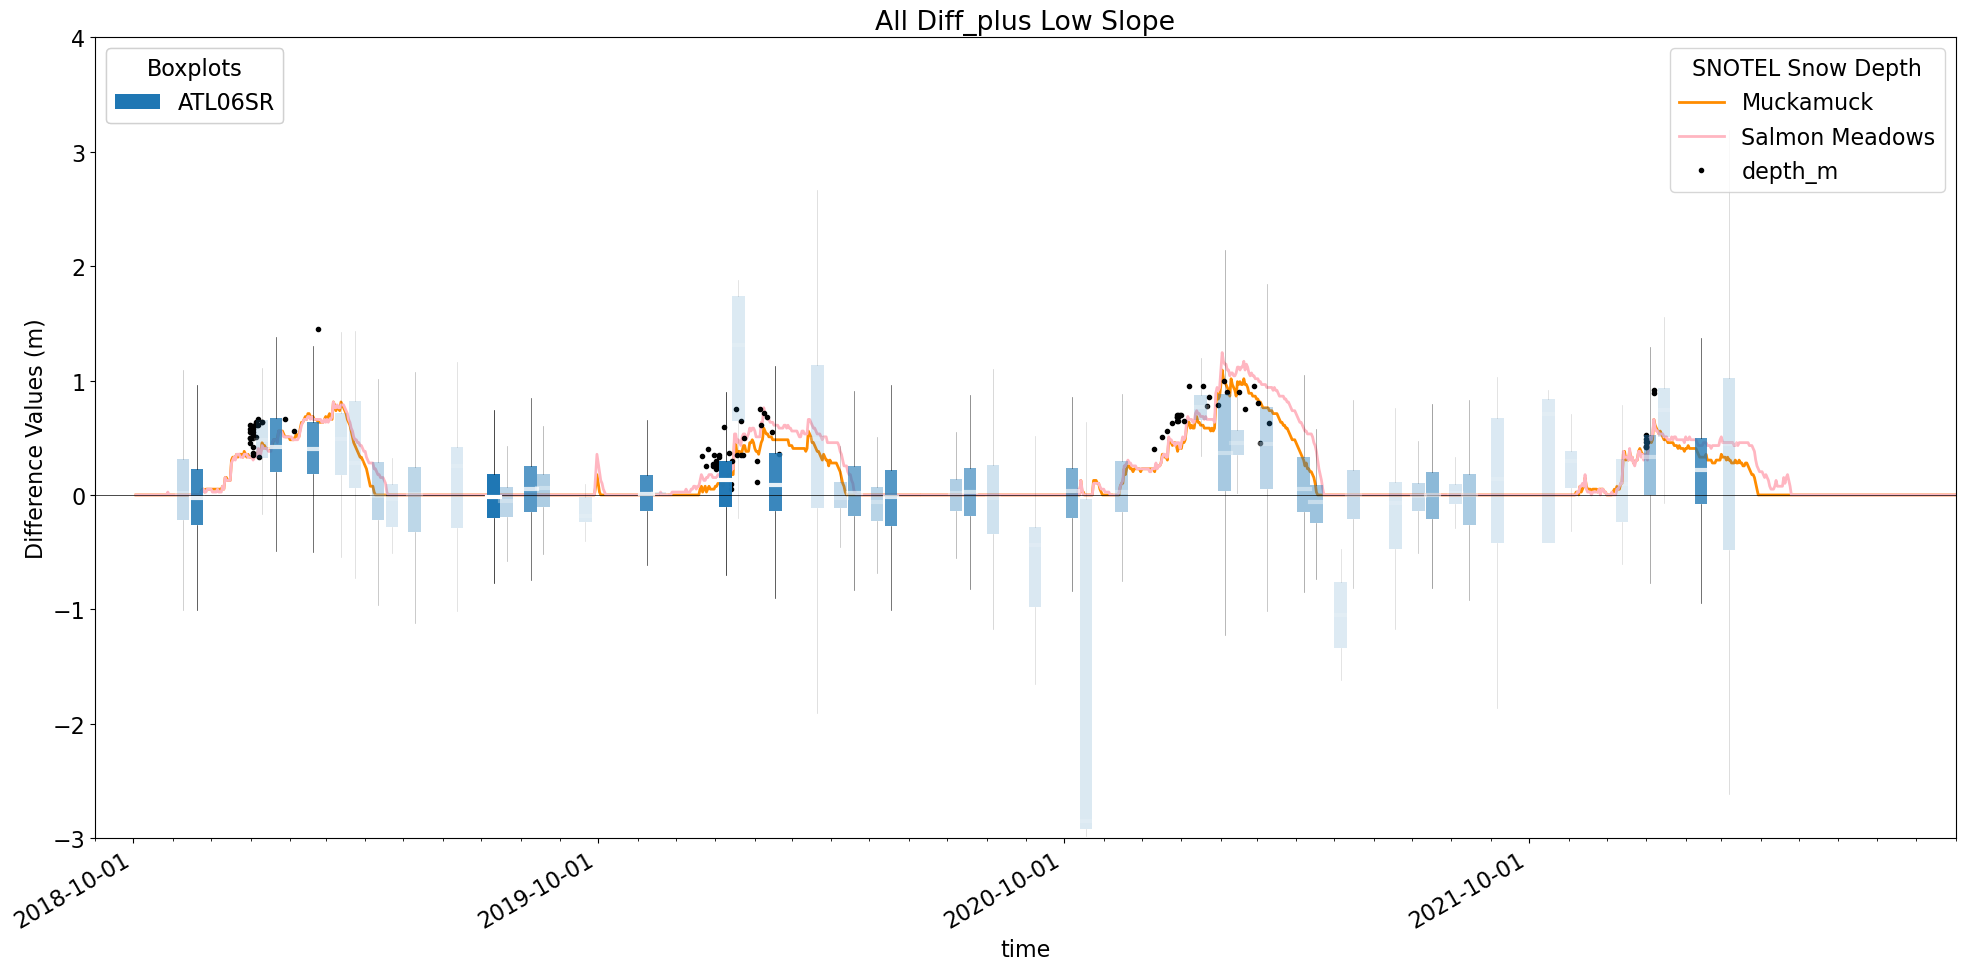

In [304]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m']<10], 'diff_plus_lowslope', clim=(-3,4), title = 'All Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

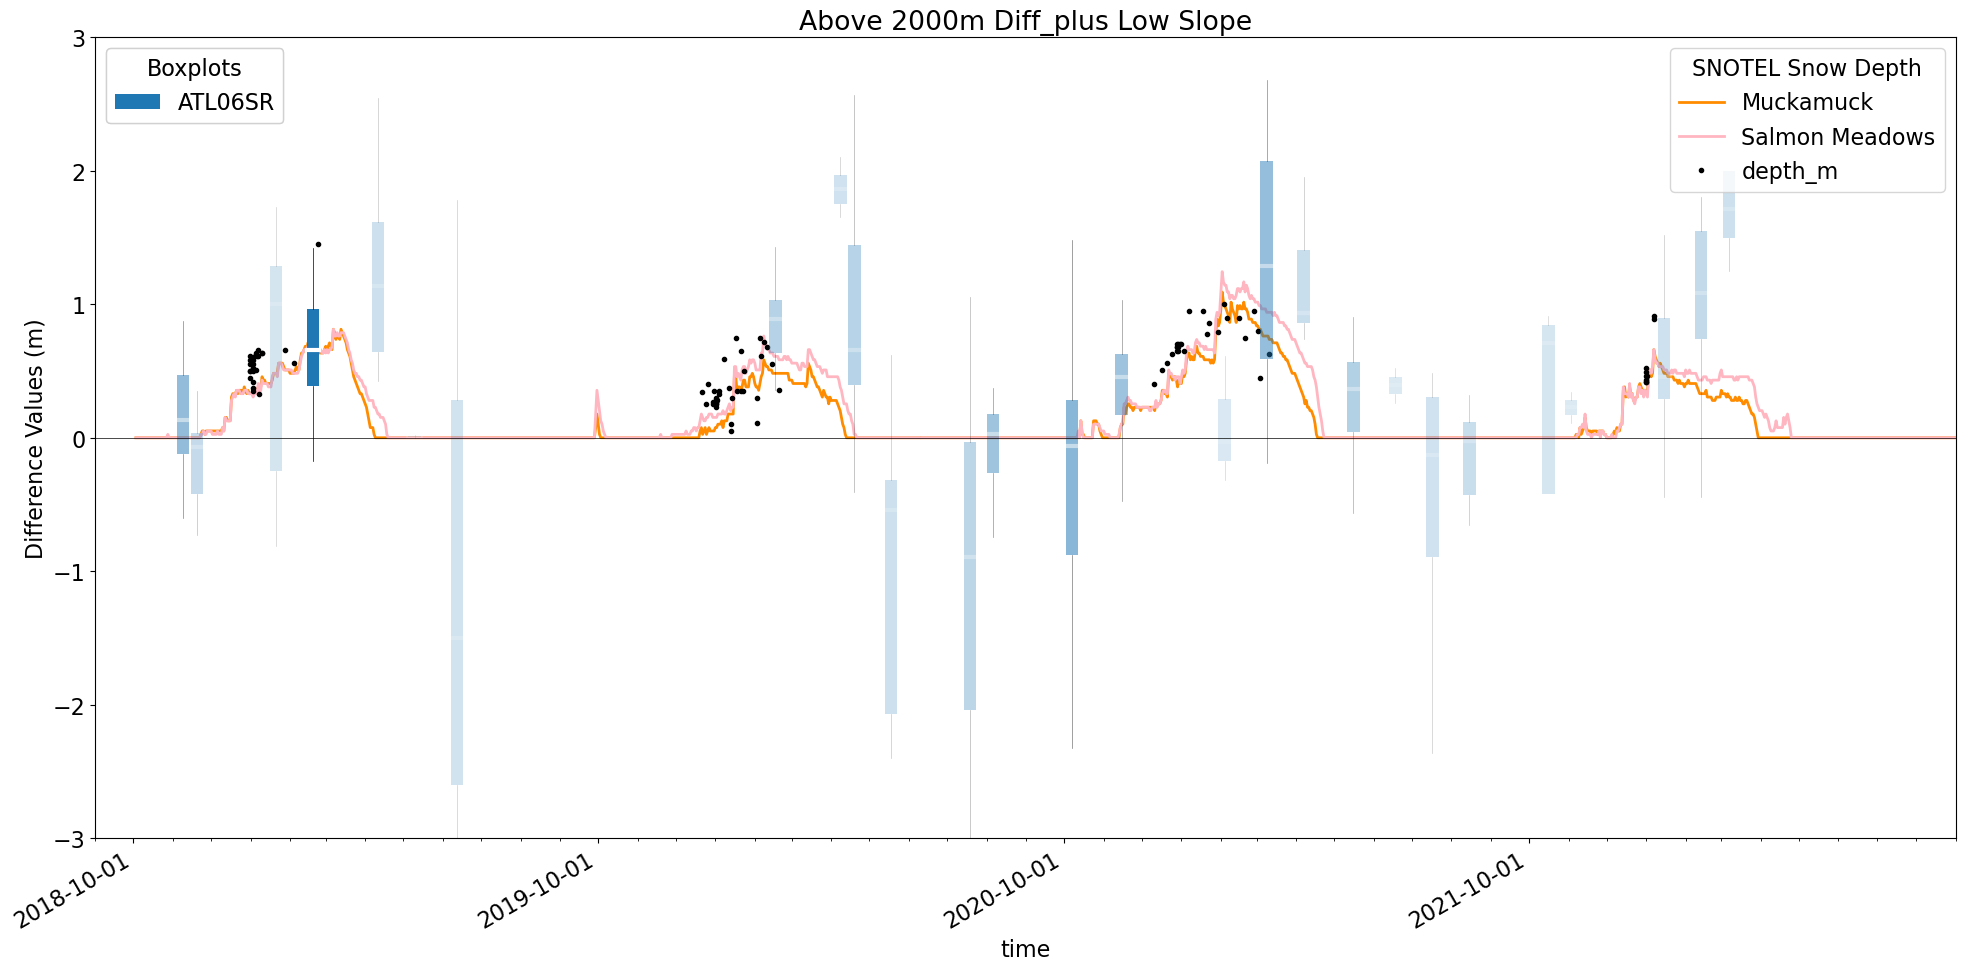

In [308]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']>2000) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', clim=(-3,3), title = 'Above 2000m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

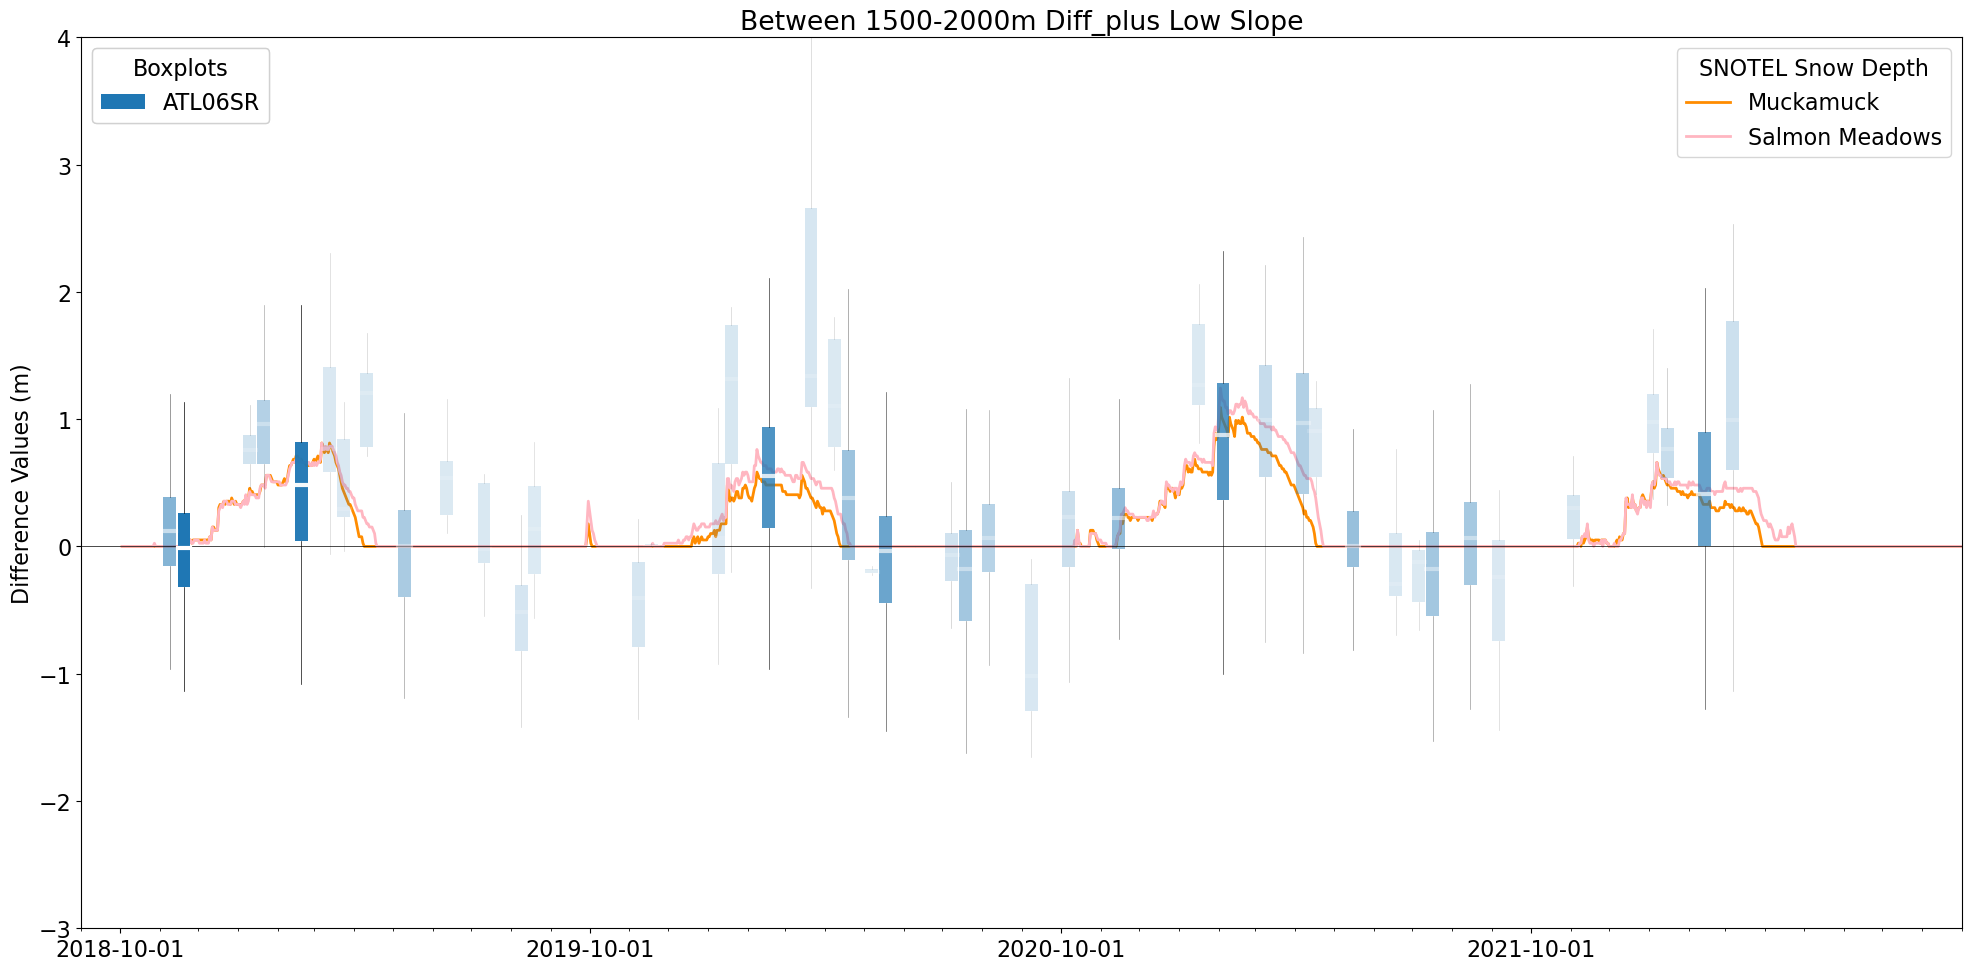

In [223]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<2000) & (atl06sr_gdf['lidar_z']>1500) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', clim=(-3,4), title = 'Between 1500-2000m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

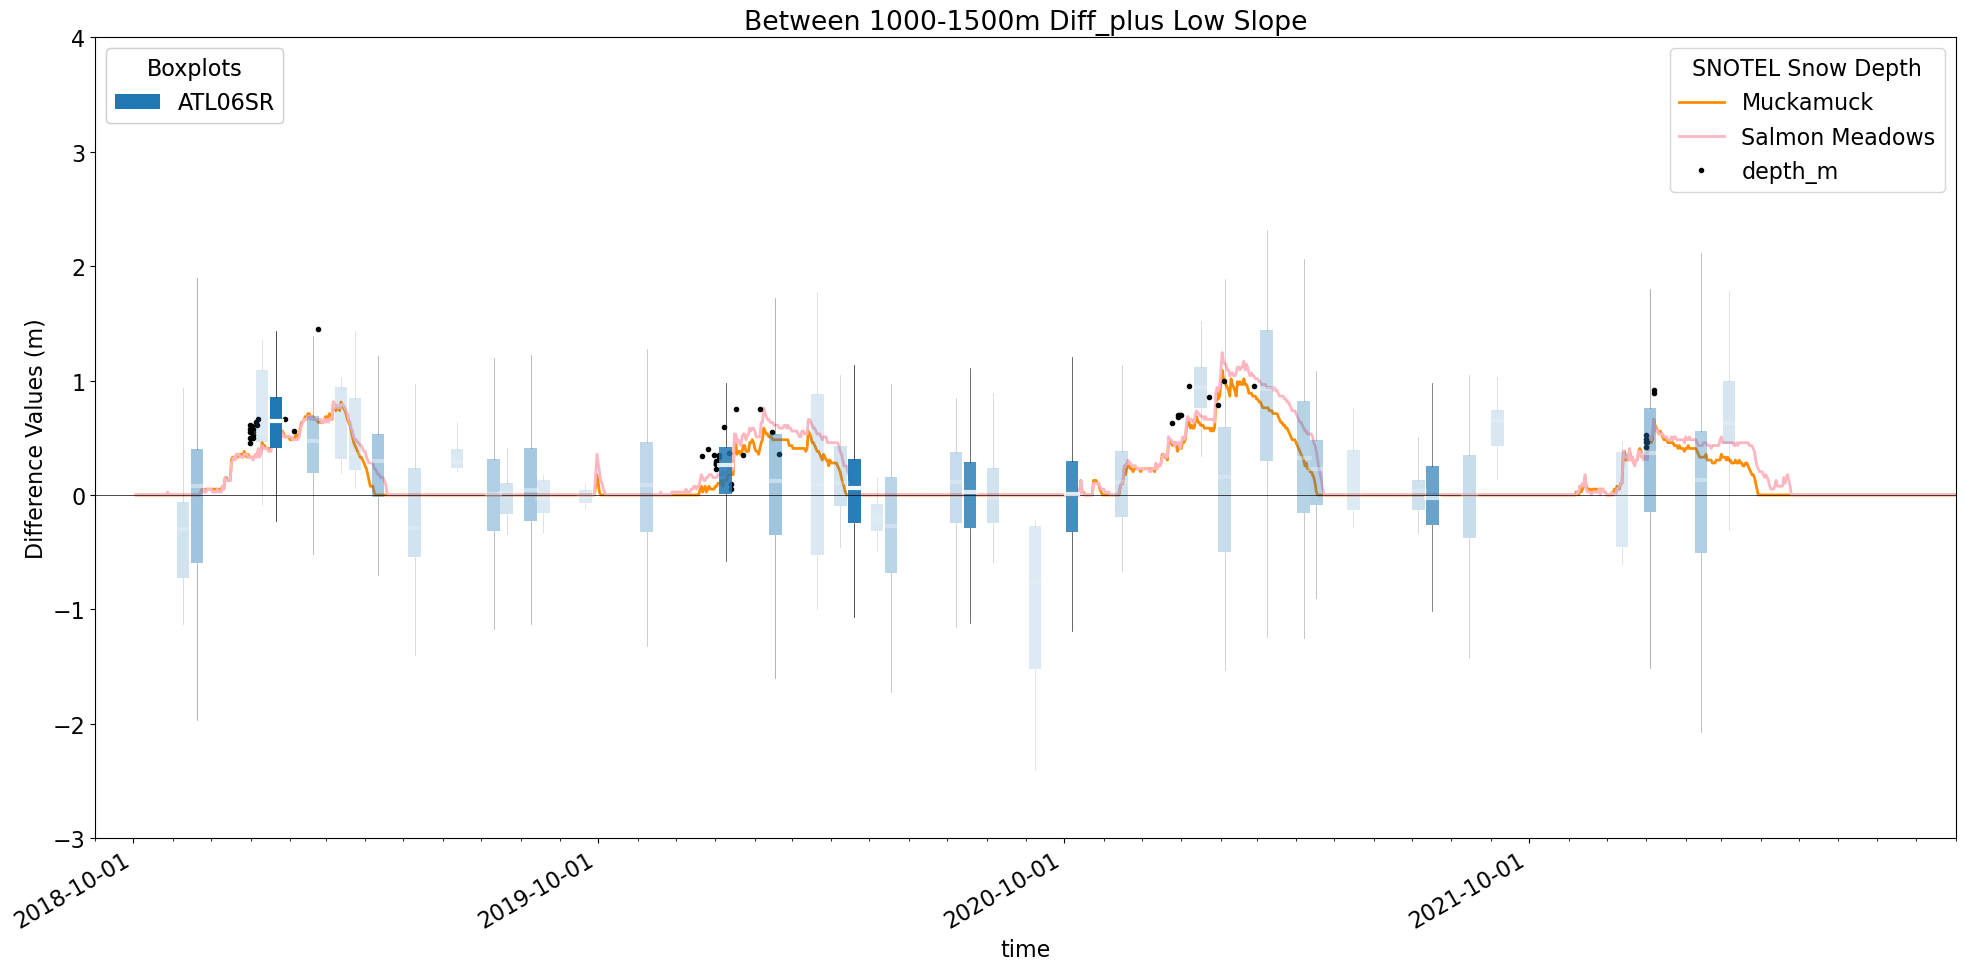

In [305]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<1500) & (atl06sr_gdf['lidar_z']>1000) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', cso_bounds=[1000, 1500], clim=(-3,4), title = 'Between 1000-1500m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

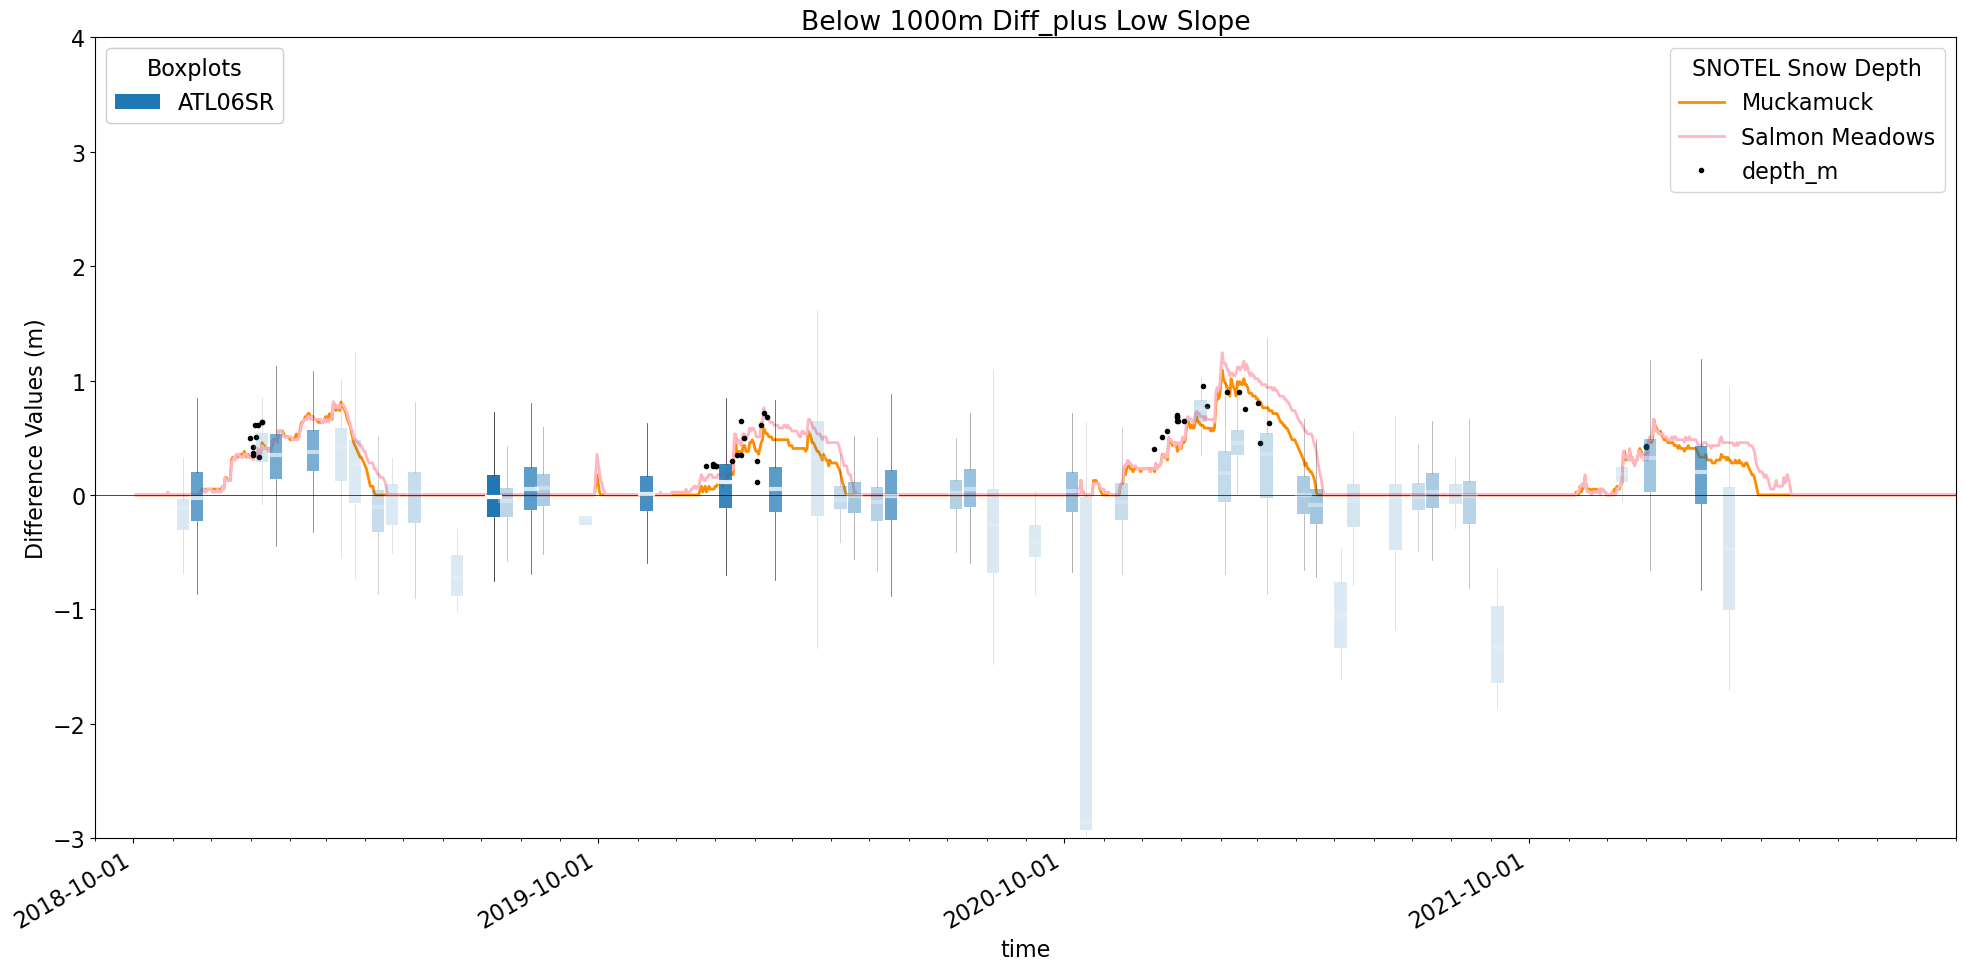

In [306]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<1000) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', cso_bounds=[0, 1000], clim=(-3,4), title = 'Below 1000m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

In [183]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks


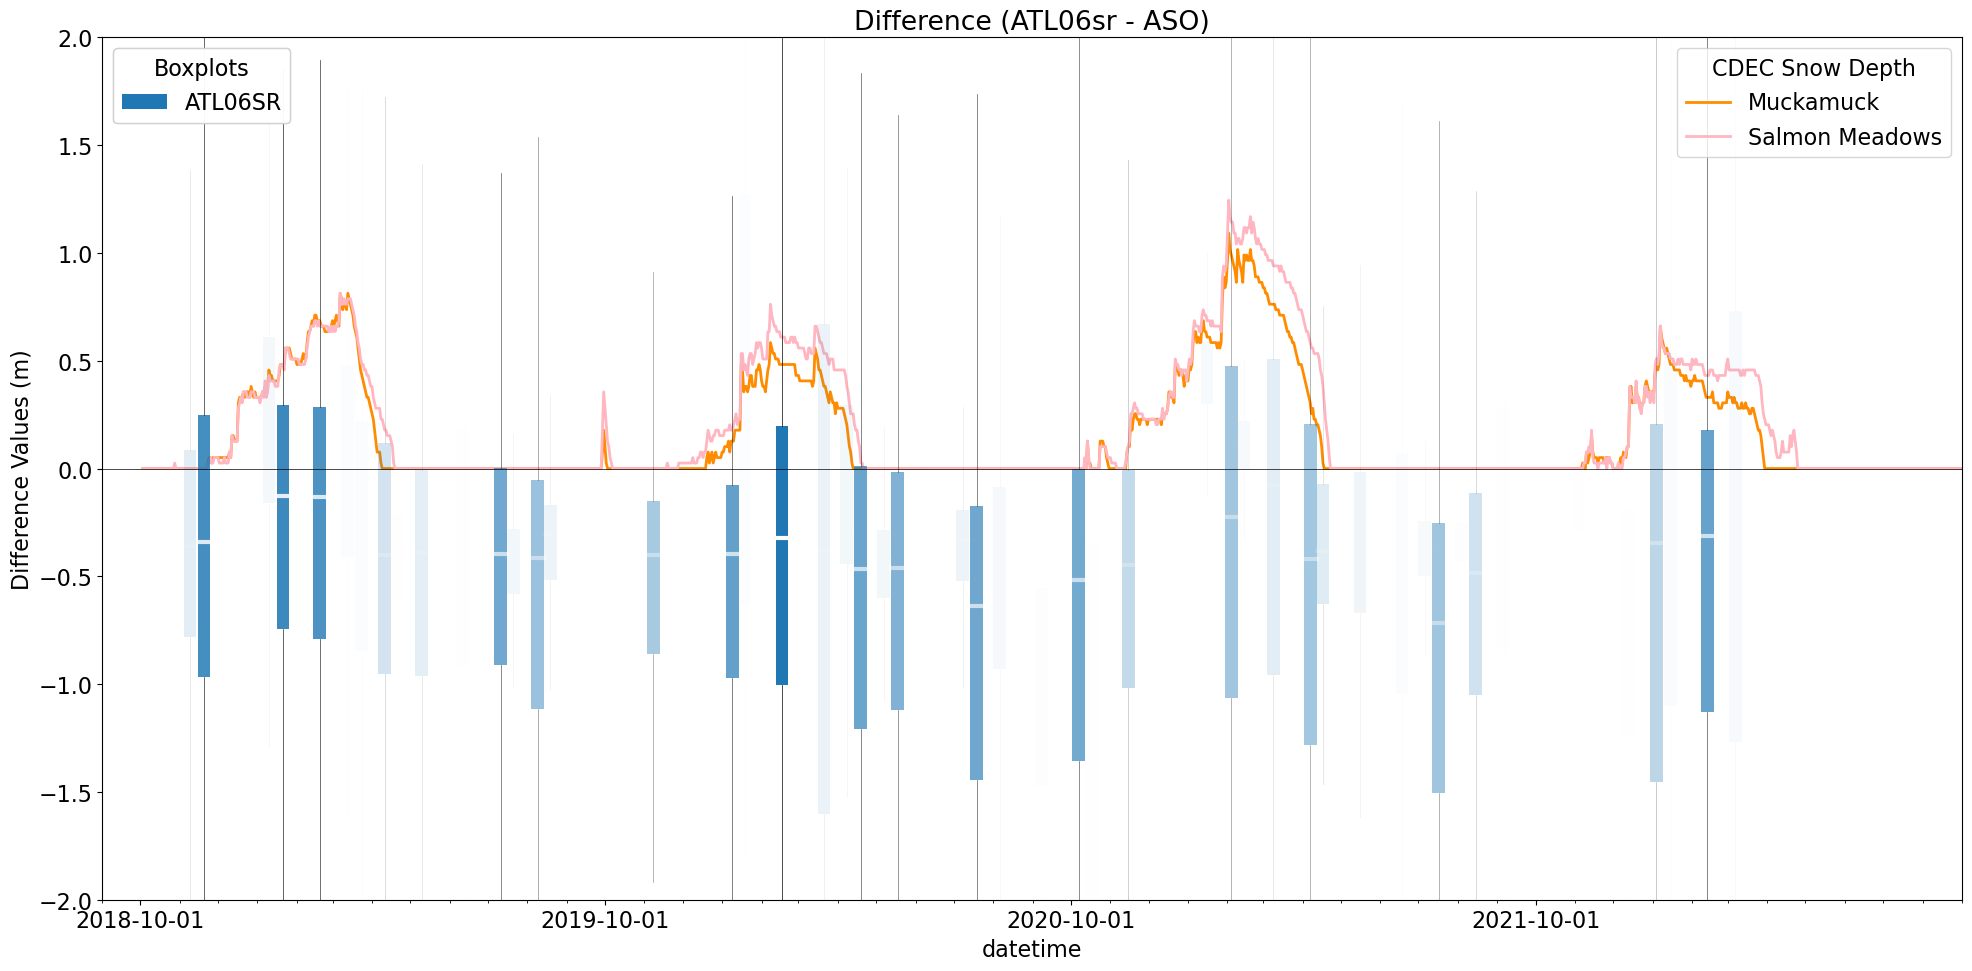

In [29]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'difference', clim=(-2,2), title='Difference (ATL06sr - ASO)', name ='boxplots_difference.jpeg')

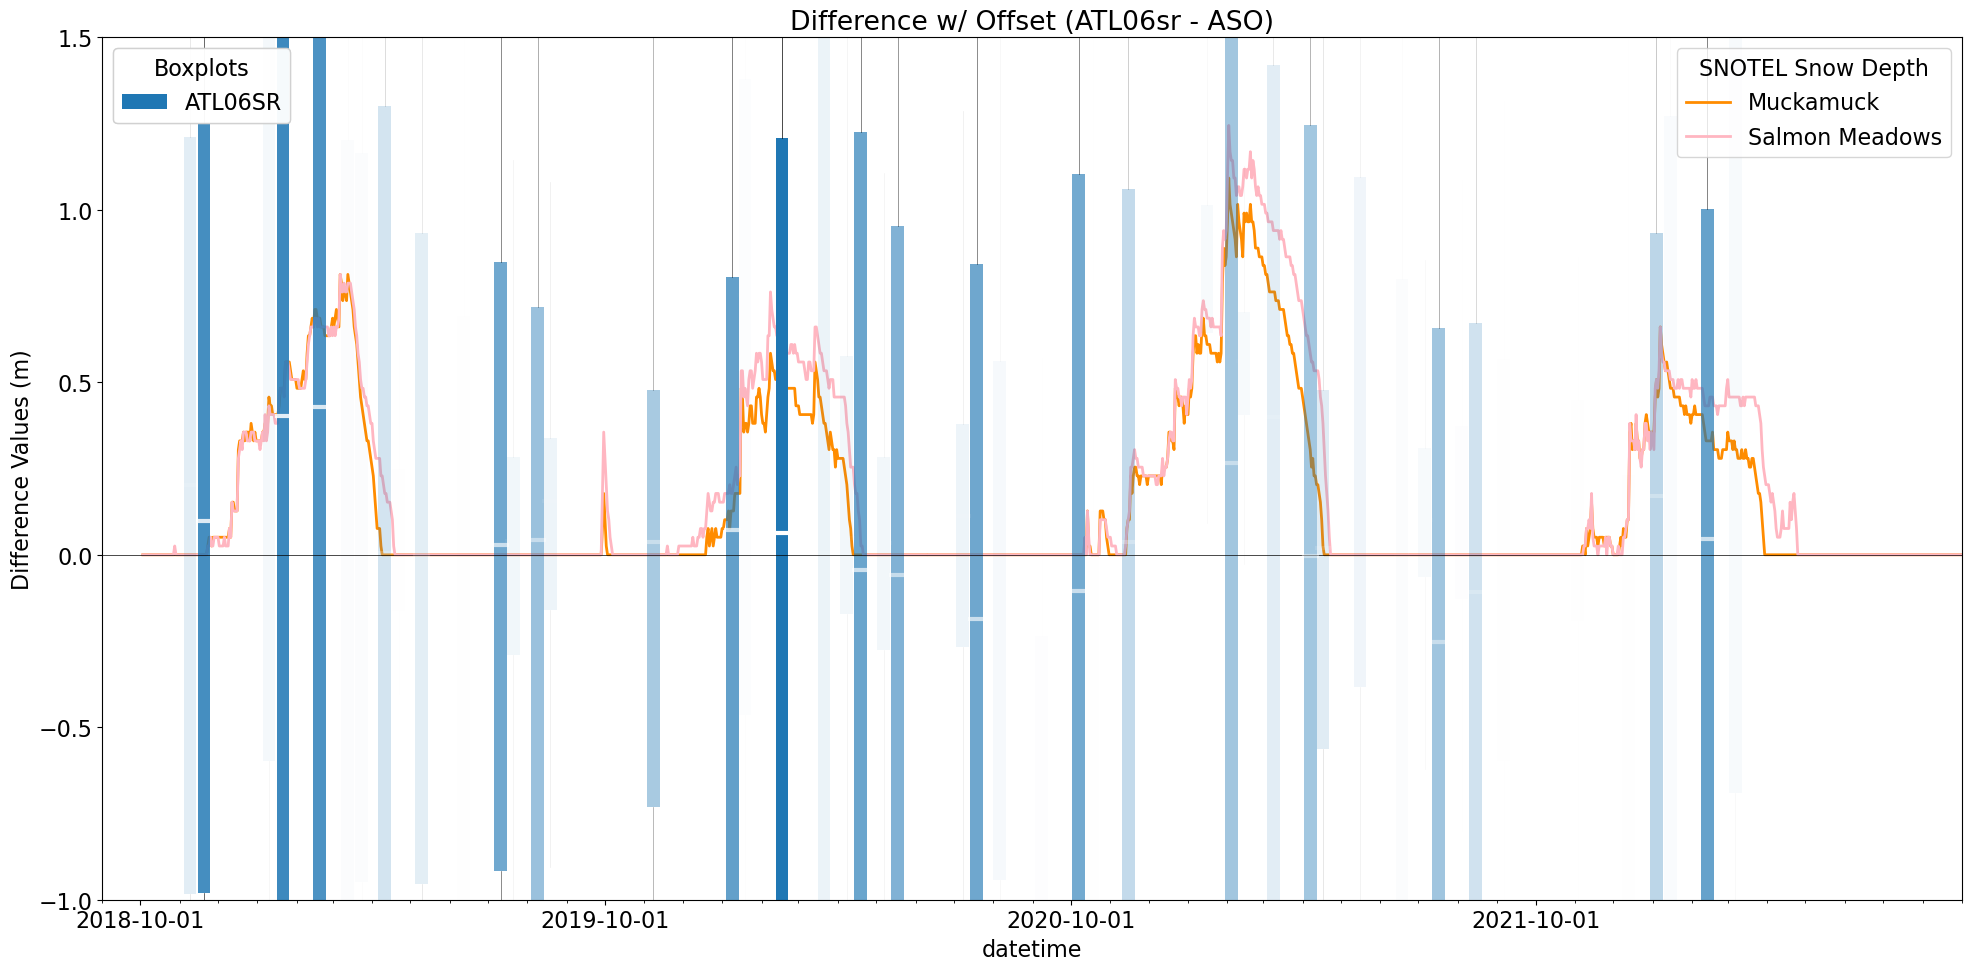

In [40]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus_20m', clim=(-1,1.5), title = 'Difference w/ Offset (ATL06sr - ASO)', name = 'boxplots_diffplus_20m')

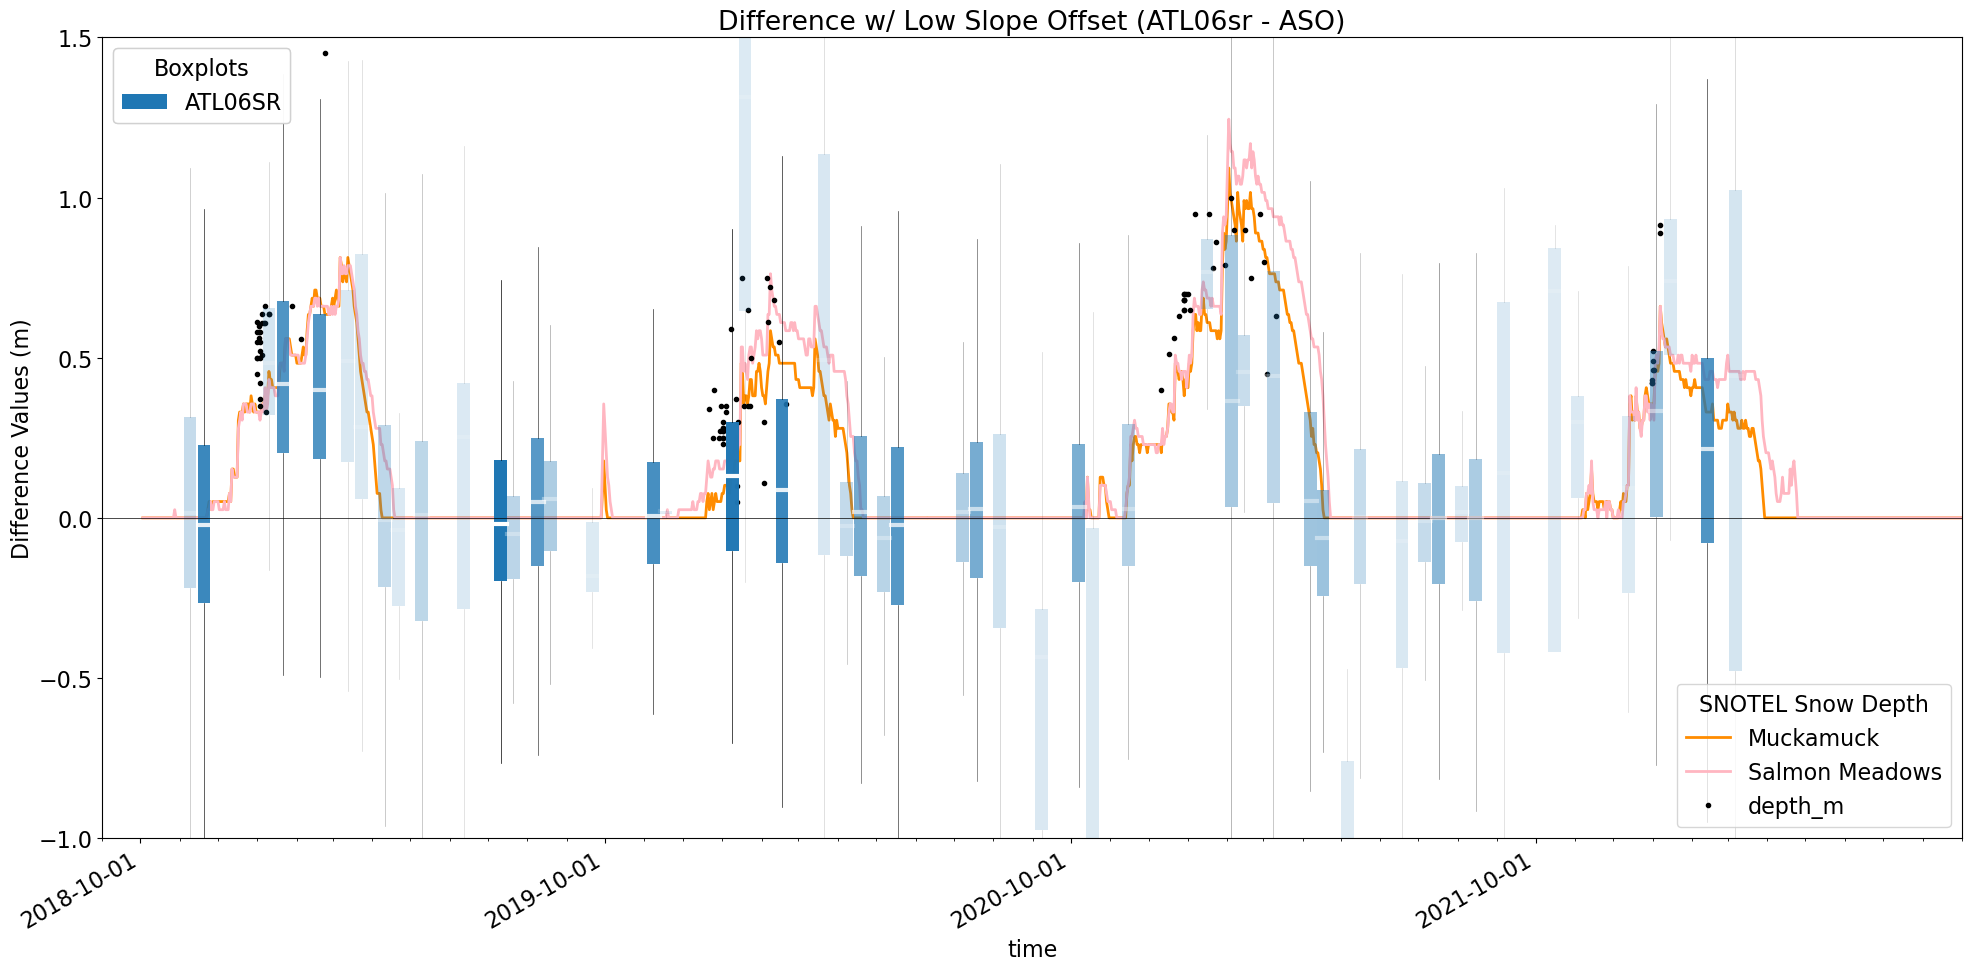

In [310]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m']<10], 'diff_plus_lowslope', clim=(-1,1.5), title = 'Difference w/ Low Slope Offset (ATL06sr - ASO)', name = 'boxplots_diffplus_lowslope_offset')

# Plot ATL06SR Data Within 5km Radius of CDEC Sites

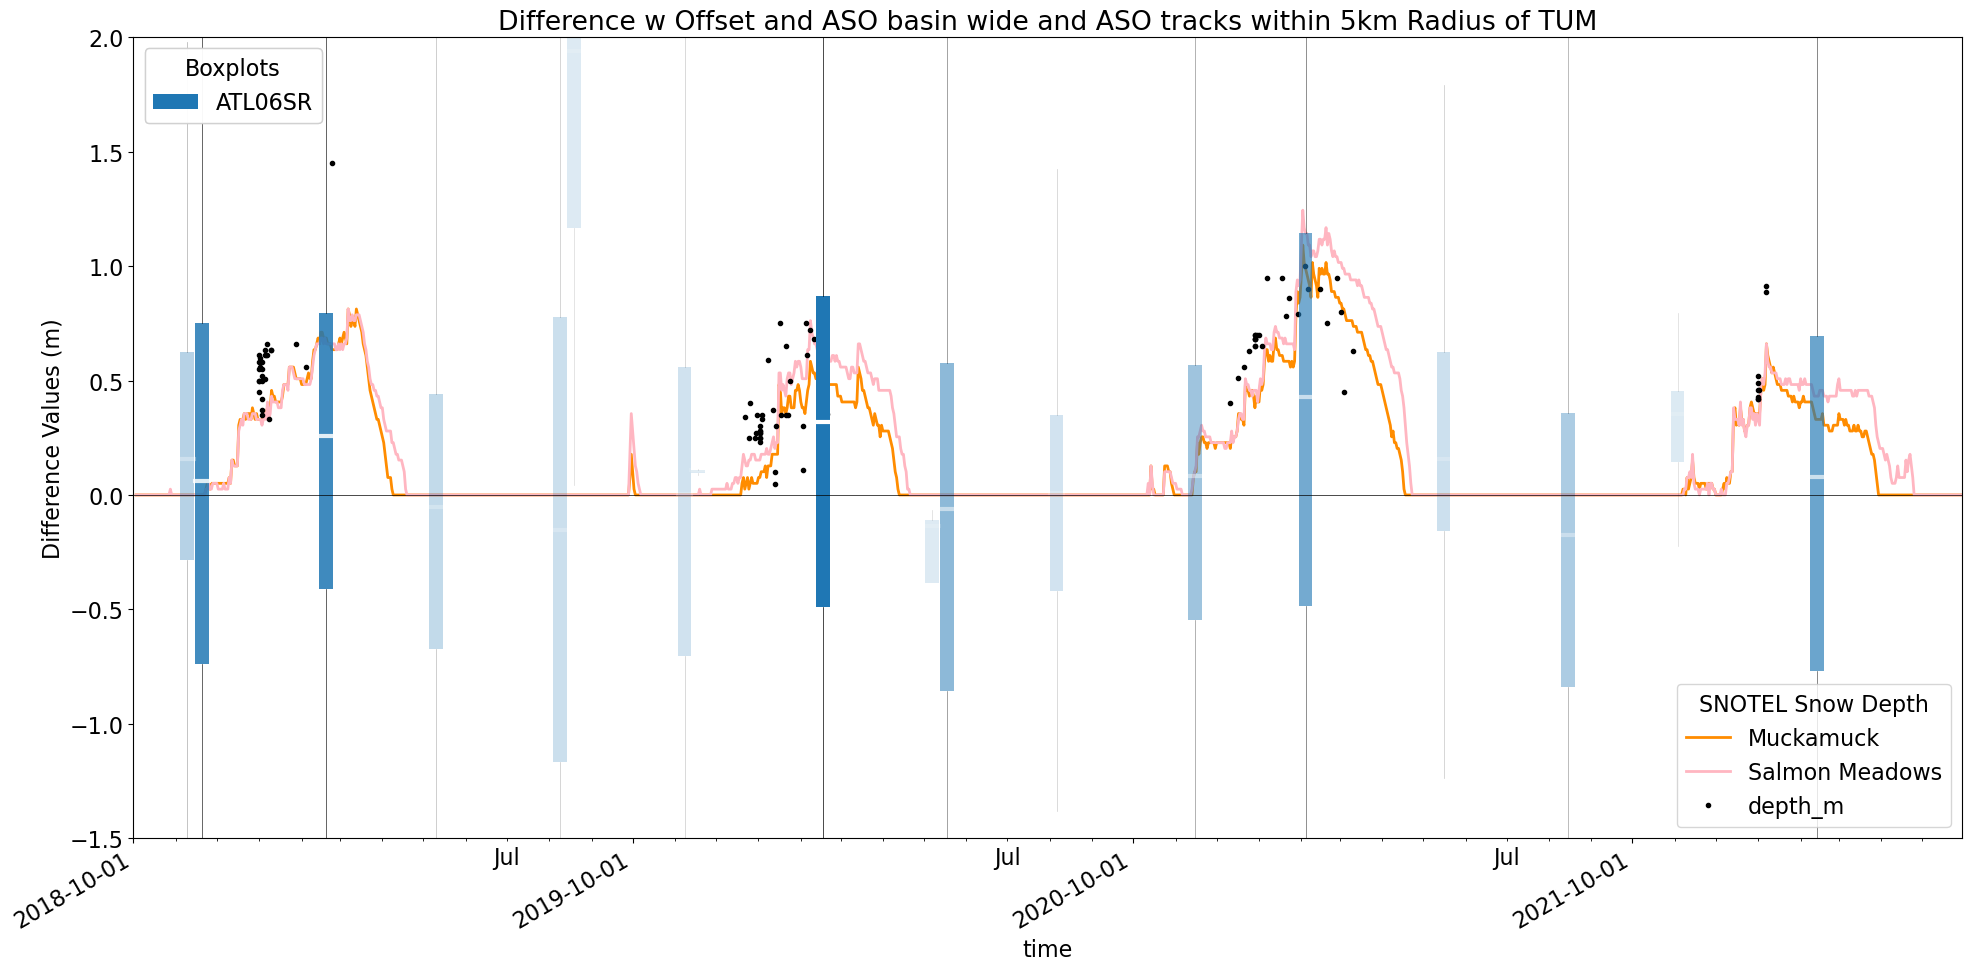

In [349]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(snotel_geom.loc[2, 'geometry'])], col='diff_plus', clim=(-1.5,2), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of TUM', name = 'boxplots_asotracks_basin_tum5.jpeg')

In [ ]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[3, 'geometry'], rasterstats=stats_dict, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of DAN', name = 'boxplots_asotracks_basin_dan5.jpeg')

# Create Comparison Table

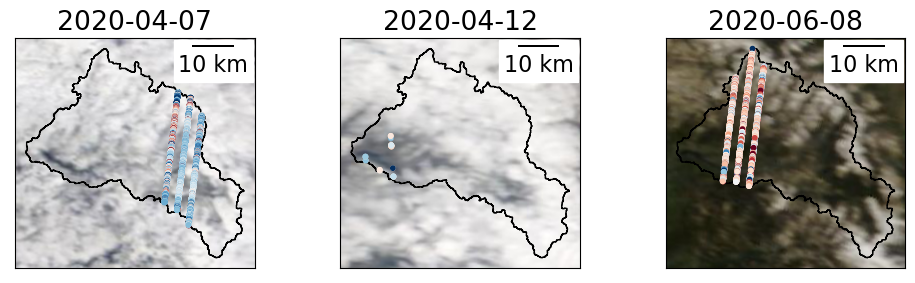

In [203]:
dates_2020 = [datetime.date(2020,4,7), datetime.date(2020,4,12), datetime.date(2020,6,8)]
s=10
basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
fig, axa = plt.subplots(1,3, figsize=(10,3))

for ax, date in zip(axa, dates_2020):
    outline_gdf.plot(ax=ax, facecolor='none')
    atl06sr_gdf[atl06sr_gdf['acqdate'] == date].plot(ax=ax, column='diff_plus', cmap = 'RdBu', legend = False, s=s, vmin = -3, vmax = 4)
    #east5.plot(ax=ax, facecolor='none')
    ax.add_artist(ScaleBar(1))
    basemap.update({'time':date})
    cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
    ax.set_title(date)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
plt.tight_layout()

In [165]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = np.nan
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus'].count()
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['muck_depth'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'muck_depth'] = snwd[snwd.index == date]['Muckamuck']
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['salm_depth'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'salm_depth'] = snwd[snwd.index == date]['Salmon Meadows']
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-muck_diff'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-muck_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'muck_depth']
    # compute the percent difference between the atl06 median depth and dana meadows.
    comp_table_all['atl06-muck_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-muck_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-muck_diff'] / comp_table_all.loc[comp_table_all.index==date,'muck_depth']) * 100
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-salm_diff'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-salm_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'salm_depth']
    # compute the percent difference between the atl06 median depth and tuolumne meadows.
    comp_table_all['atl06-salm_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-salm_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-salm_diff'] / comp_table_all.loc[comp_table_all.index==date,'salm_depth']) * 100
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['snotel_mean'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snotel_mean'] = (comp_table_all.loc[comp_table_all.index==date,'muck_depth'] + comp_table_all.loc[comp_table_all.index==date,'salm_depth']) / 2
    # compute the percent difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-snotel_mean'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'snotel_mean']
    comp_table_all['atl06-snotel_mean_percent'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-snotel_mean'] / comp_table_all.loc[comp_table_all.index==date,'snotel_mean']) * 100
    comp_table_all['snow_presence'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])
    
    return comp_table_all

In [166]:
comp_df = make_comparison_table(atl06sr_gdf)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_38810/2340614932.py:54: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [365]:
comp_df

,acqdate,median,iqr,n,muck_depth,salm_depth,atl06-muck_diff,atl06-muck_percent,atl06-salm_diff,atl06-salm_percent,snotel_mean,atl06-snotel_mean,atl06-snotel_mean_percent,snow_presence
2018-11-09,2018-11-09,0.079784,0.871998,1468.0,0.0000,0.0000,0.079784,inf,0.079784,inf,0.0000,0.079784,inf,0.0
2018-11-20,2018-11-20,0.097591,1.217619,9835.0,0.0000,0.0000,0.097591,inf,0.097591,inf,0.0000,0.097591,inf,0.0
2019-01-10,2019-01-10,0.629287,0.769268,535.0,0.4572,0.4318,0.172087,37.639321,0.197487,45.735752,0.4445,0.184787,41.571873,1.0
2019-01-21,2019-01-21,0.312073,1.040378,10254.0,0.4826,0.4826,-0.170527,-35.335152,-0.170527,-35.335152,0.4826,-0.170527,-35.335152,1.0
2019-02-19,2019-02-19,0.307656,1.076832,9487.0,0.6858,0.6604,-0.378144,-55.139122,-0.352744,-53.413704,0.6731,-0.365444,-54.292691,1.0
2019-03-13,2019-03-13,0.536210,0.893380,171.0,0.8128,0.7874,-0.276590,-34.029255,-0.251190,-31.901167,0.8001,-0.263890,-32.982101,1.0
2019-03-24,2019-03-24,0.096640,1.085696,164.0,0.4318,0.4826,-0.335160,-77.619271,-0.385960,-79.975138,0.4572,-0.360560,-78.862645,1.0
2019-04-11,2019-04-11,0.037095,1.072149,2300.0,0.0000,0.1778,0.037095,inf,-0.140705,-79.136592,0.0889,-0.051805,-58.273183,0.0
2019-04-22,2019-04-22,0.090759,0.402740,39.0,0.0000,0.0000,0.090759,inf,0.090759,inf,0.0000,0.090759,inf,0.0
2019-05-10,2019-05-10,0.046017,0.950986,1446.0,0.0000,0.0000,0.046017,inf,0.046017,inf,0.0000,0.046017,inf,0.0


In [ ]:
np.nanmedian(comp_table[''])

In [366]:
atl06sr_gdf.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate,doy,decyear,dowy,snow_presence,lidar_z,difference,lidar_z_20m,difference_20m,slope_3m,slope_20m,slope_100m,diff_plus,diff_plus_20m,zscore,n,diff_plus_lowslope
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (722265.057 5358346.501),2018-11-09,313,2018.857324,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1468.0,NaN
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (722145.580 5359238.959),2018-11-09,313,2018.857324,40,0,921.263184,-1.321359,924.401428,-4.459604,21.903059,11.596403,NaN,-0.881577,-4.024133,-0.667243,1468.0,-0.968813


In [367]:
np.nanmedian(atl06sr_gdf[atl06sr_gdf['snow_presence']==1]['diff_plus'])

0.1777582017409145

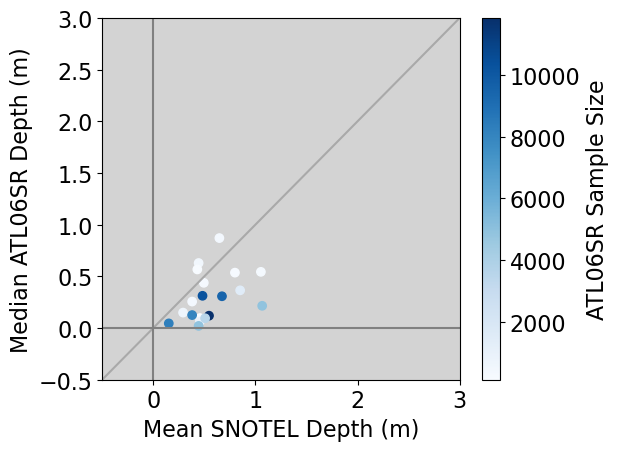

In [169]:
x = np.linspace(-0.7,3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_df[comp_df['snow_presence']==1]['snotel_mean'], comp_df[comp_df['snow_presence']==1]['median'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=3, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=3, color='grey')
plt.colorbar(c, label='ATL06SR Sample Size')
plt.ylim(-0.5, 3)
plt.xlim(-0.5, 3)
plt.xlabel('Mean SNOTEL Depth (m)')
plt.ylabel('Median ATL06SR Depth (m)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
#plt.savefig('../../figures/polished/median_dif_vs_delta_dan.jpeg', dpi=500)

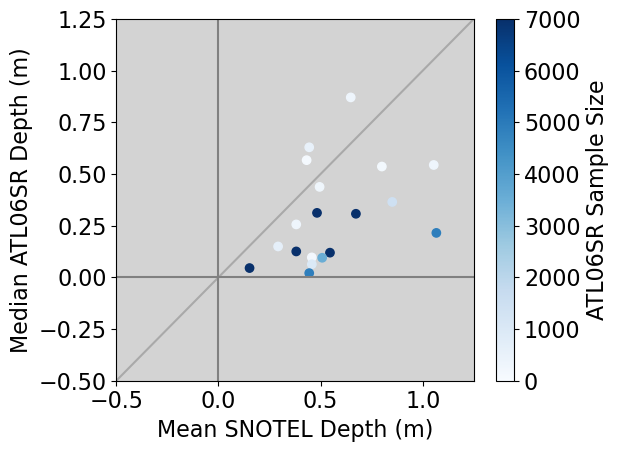

In [168]:
x = np.linspace(-0.7,3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_df[comp_df['snow_presence']==1]['snotel_mean'], comp_df[comp_df['snow_presence']==1]['median'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues', vmin=0, vmax=7000)
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=1.5, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=1.5, color='grey')
plt.colorbar(c, label='ATL06SR Sample Size')
plt.ylim(-0.5, 1.25)
plt.xlim(-0.5, 1.25)
plt.xlabel('Mean SNOTEL Depth (m)')
plt.ylabel('Median ATL06SR Depth (m)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
plt.savefig('../../figures/polished/median_dif_vs_delta_snotel.jpeg', dpi=500)

In [311]:
comp_df.head(2)

,acqdate,median,iqr,n,muck_depth,salm_depth,atl06-muck_diff,atl06-muck_percent,atl06-salm_diff,atl06-salm_percent,snotel_mean,atl06-snotel_mean,atl06-snotel_mean_percent,snow_presence
2018-11-09,2018-11-09,0.079784,0.871998,1468.0,0.0,0.0,0.079784,inf,0.079784,inf,0.0,0.079784,inf,0.0
2018-11-20,2018-11-20,0.097591,1.217619,9835.0,0.0,0.0,0.097591,inf,0.097591,inf,0.0,0.097591,inf,0.0


In [317]:
np.nanmedian(comp_df['atl06-snotel_mean'].abs())

0.13889889863276283

In [316]:
np.nanmedian(comp_df[comp_df['snow_presence']==1]['atl06-snotel_mean'].abs())

0.26388978769627114

In [318]:
np.nanmedian(comp_df['atl06-snotel_mean_percent'].abs())

inf

In [315]:
np.nanmedian(comp_df[comp_df['snow_presence']==1]['atl06-snotel_mean_percent'].abs())

54.292690717446845

In [370]:
np.nanstd(atl06sr_gdf[atl06sr_gdf['snow_presence']==1]['diff_plus'])

1.212294028291108

In [371]:
np.nanstd(atl06sr_gdf[atl06sr_gdf['snow_presence']==0]['diff_plus'])

1.1939543798429277

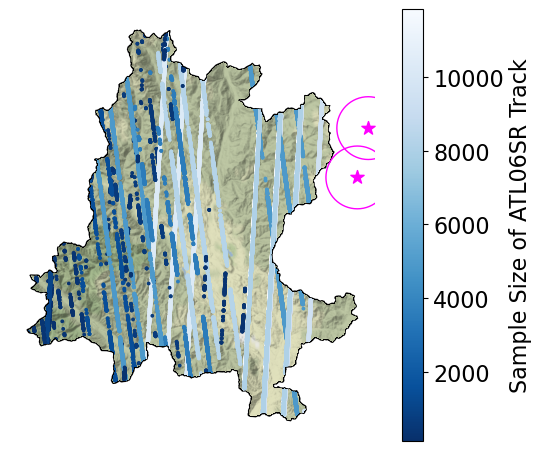

In [307]:
basemap = cx.providers.Stamen.TerrainBackground

fig, ax = plt.subplots()

atl06sr_gdf[atl06sr_gdf['snow_presence']==1].plot(column='n', cmap='Blues_r', ax=ax, markersize=3, legend=True, legend_kwds={'label':'Sample Size of ATL06SR Track'})
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')
cx.add_basemap(ax=ax, attribution=False, crs='epsg:32610', source=basemap, zoom=11)
methow_reverse.plot(ax=ax, facecolor='white')
snotel_geom[0:2].plot(ax=ax, color='magenta', marker='*', markersize=100)
snotel_geom[2:].plot(ax=ax, facecolor='none',edgecolor='magenta')
ax.set_axis_off()
plt.tight_layout()
#plt.savefig('../../figures/date_offset_map.jpeg', dpi=300)

## Compute the Data Table for Radius Area  
Still a work in progress for the Methow, since the radius is too small to include the study area

In [320]:
snotel_geom

,code,name,network,elevation_m,site_property,geometry,elevation_transformed,site
0,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055,NaN
1,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959,NaN
2,NaN,NaN,NaN,NaN,NaN,"POLYGON ((751093.784 5386094.282, 750997.478 5...",NaN,muck_20km
3,NaN,NaN,NaN,NaN,NaN,"POLYGON ((752831.735 5393950.294, 752735.429 5...",NaN,salmon_20km


In [324]:
comp_muckradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(snotel_geom.loc[2, 'geometry'])])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_38810/2340614932.py:54: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [325]:
comp_salmradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(snotel_geom.loc[3, 'geometry'])])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_38810/2340614932.py:54: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [326]:
comp_muckradius.head()

,acqdate,median,iqr,n,muck_depth,salm_depth,atl06-muck_diff,atl06-muck_percent,atl06-salm_diff,atl06-salm_percent,snotel_mean,atl06-snotel_mean,atl06-snotel_mean_percent,snow_presence
2018-11-09,2018-11-09,0.155971,0.906745,1217.0,0.0000,0.0000,0.155971,inf,0.155971,inf,0.0000,0.155971,inf,0.0
2018-11-20,2018-11-20,0.062488,1.490338,4851.0,0.0000,0.0000,0.062488,inf,0.062488,inf,0.0000,0.062488,inf,0.0
2019-02-19,2019-02-19,0.255973,1.204258,4955.0,0.6858,0.6604,-0.429827,-62.675341,-0.404427,-61.239777,0.6731,-0.417127,-61.971102,1.0
2019-05-10,2019-05-10,-0.051865,1.112144,852.0,0.0000,0.0000,-0.051865,-inf,-0.051865,-inf,0.0000,-0.051865,-inf,0.0
2019-08-09,2019-08-09,-0.151120,1.944889,583.0,0.0000,0.0000,-0.151120,-inf,-0.151120,-inf,0.0000,-0.151120,-inf,0.0


In [328]:
comp_muckradius = comp_muckradius.drop(columns=['atl06-salm_diff', 'atl06-salm_percent', 'salm_depth'])

In [331]:
comp_salmradius = comp_salmradius.drop(columns=['muck_depth', 'atl06-muck_diff', 'atl06-muck_percent'])

In [332]:
comp_muckradius.to_csv('../../figures/comp_muckradius.csv')
comp_salmradius.to_csv('../../figures/comp_salmradius.csv')

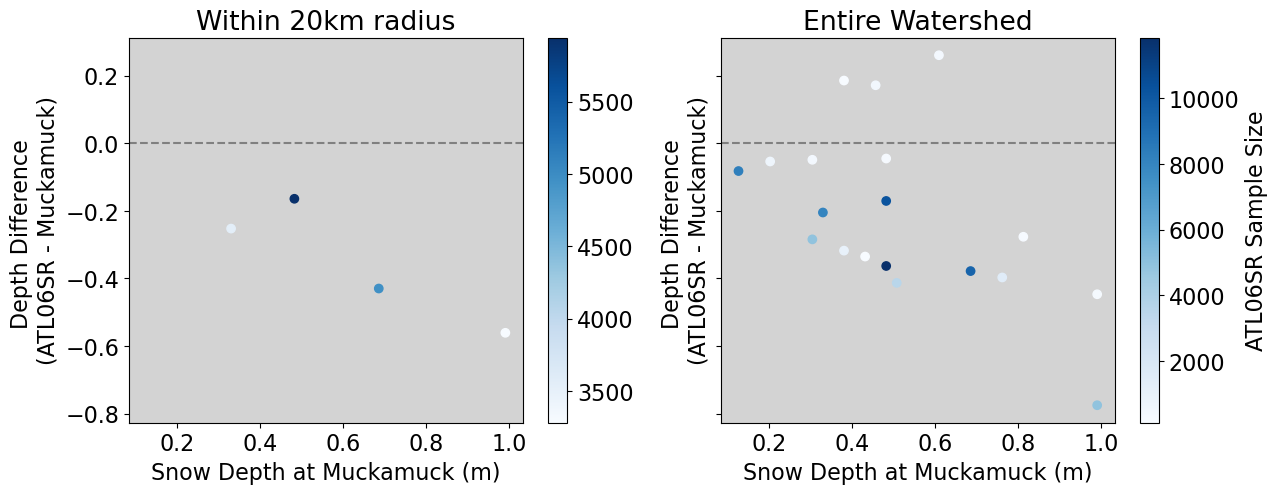

In [345]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_muckradius[comp_muckradius['snow_presence']==1]['muck_depth'], comp_muckradius[comp_muckradius['snow_presence']==1]['atl06-muck_diff'], c=comp_muckradius[comp_muckradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at Muckamuck (m)')
ax[0].set_ylabel('Depth Difference \n(ATL06SR - Muckamuck)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 20km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['muck_depth'], comp_df[comp_df['snow_presence']==1]['atl06-muck_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at Muckamuck (m)')
ax[1].set_ylabel('Depth Difference \n(ATL06SR - Muckamuck)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

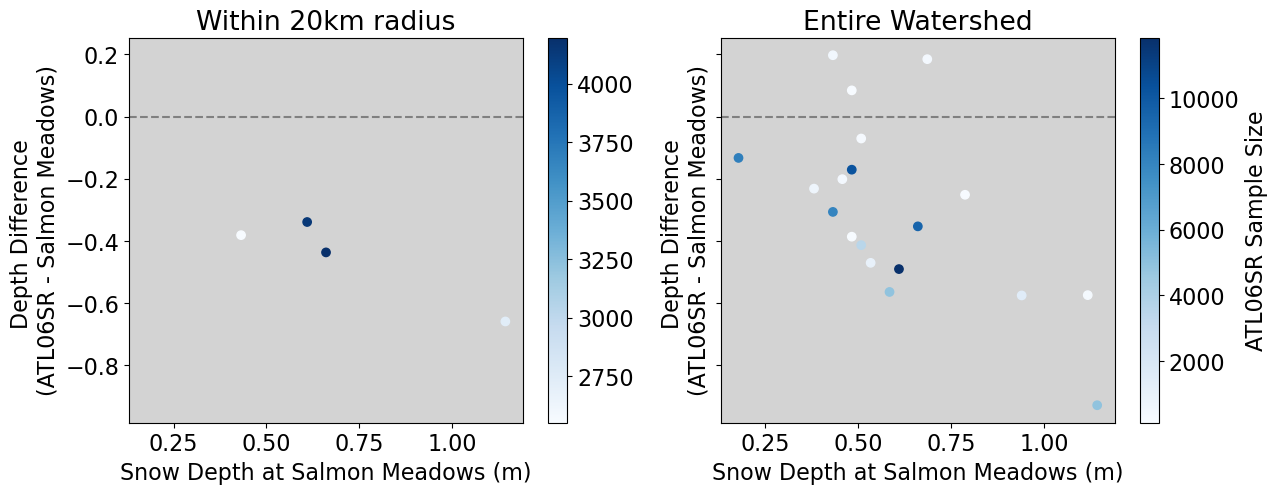

In [346]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_salmradius[comp_salmradius['snow_presence']==1]['salm_depth'], comp_salmradius[comp_salmradius['snow_presence']==1]['atl06-salm_diff'], c=comp_salmradius[comp_salmradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at Salmon Meadows (m)')
ax[0].set_ylabel('Depth Difference \n(ATL06SR - Salmon Meadows)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 20km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['salm_depth'], comp_df[comp_df['snow_presence']==1]['atl06-salm_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at Salmon Meadows (m)')
ax[1].set_ylabel('Depth Difference \n(ATL06SR - Salmon Meadows)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
#ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

In [340]:
np.nanmedian(comp_muckradius['atl06-muck_diff'].abs())

0.15354557895921062

In [341]:
np.nanmedian(comp_muckradius['atl06-muck_percent'].abs())

inf

In [350]:
for data in [(comp_df[comp_df['snow_presence']==1]['iqr']), comp_df[comp_df['snow_presence']==1]['atl06-muck_diff'], \
             comp_df[comp_df['snow_presence']==1]['atl06-muck_percent'], comp_df[comp_df['snow_presence']==1]['atl06-salm_diff'], \
            comp_df[comp_df['snow_presence']==1]['atl06-salm_percent'], comp_muckradius[comp_muckradius['snow_presence']==1]['iqr'], \
            comp_muckradius[comp_muckradius['snow_presence']==1]['atl06-muck_diff'], comp_muckradius[comp_muckradius['snow_presence']==1]['atl06-muck_percent'], \
            comp_salmradius[comp_salmradius['snow_presence']==1]['atl06-salm_diff'], comp_salmradius[comp_salmradius['snow_presence']==1]['atl06-salm_percent'], \
            comp_salmradius[comp_salmradius['snow_presence']==1]['iqr']]:
    print(f'{data.name}', 'median =', np.nanmedian(data.abs()))

iqr median = 1.2004008985475139
atl06-muck_diff median = 0.27658978769627107
atl06-muck_percent median = 52.11110967303222
atl06-salm_diff median = 0.30630808267107046
atl06-salm_percent median = 60.74144542396408
iqr median = 1.4112059775322905
atl06-muck_diff median = 0.34108560873905436
atl06-muck_percent median = 59.65253166196436
atl06-salm_diff median = 0.4087230515944826
atl06-salm_percent median = 61.85308263244024
iqr median = 1.4393965430244293


## Old, less universal plotting functions:

In [157]:
# # Function adapted from David Shean by Hannah Besso
# # Uses boxplot transparency to indicate sample size

# def boxplot_date_alpha(df, col, groupby_col='acqdate', clim=(-5, 5), title = 'ATL06sr - ASO', name='../Figures/boxplots_cdec.jpeg'):
#     bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
#     bp_stats_list = [i[0] for i in bp_stats.values]
#     bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
#     bp_alpha_boxes = bp_alpha/bp_alpha.max()
#     pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
#     f, ax = plt.subplots(figsize=(20,10))
#     bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
#                    whiskerprops={'lw':0.5, 'alpha':0.2}, medianprops={'lw':3}, 
#                    widths=10, patch_artist=True)
    
#     #set the alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#     for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#         patch.set_color('white')  # or deeppink
#     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
#         patch.set_alpha(alpha)
    
#     #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
#     snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
#     snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
#     ax.axhline(0, color='k', lw=0.5)
#     ax.set_ylabel('Difference Values (m)')
#     ax.set_ylim(*clim)
#     ax.set_xlim([dt_min_plot, dt_max_plot])
#     #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.legend(loc='lower right', title='CDEC Snow Depth')
#     ax.set_title(title)
    
#     #ax.xaxis.set_major_locator(MulitpleLocator(6))
#     years = mdates.YearLocator(month=10)
#     years_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)

#     april = mdates.MonthLocator()
#     months_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_minor_locator(april)
#     #ax.xaxis.set_minor_formatter(months_fmt)
#     #ax.tick_params(axis="x", which="both", rotation=35, right=True)
#     #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    
#     plt.tight_layout()
#     #plt.savefig(name, dpi=500)

In [158]:
def boxplot_date_aso(df, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', 
                     clim=(-5, 5), title = 'Difference (ATL06sr - ASO)', name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, patch_artist=True,
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3}, widths=10)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, patch_artist=True,
                    whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10)

    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_color('mediumvioletred')
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots')
    #legend2.set_alpha(1)
    ax.add_artist(legend1)
    ax.add_artist(legend2)  
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_alpha(alpha)    
    for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
        patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)